# Definition of Clock, MG and ML scores 

## Introduction

After cleaning the methylation data from TME effects we went on to look for global trends in the methylation data, i.e. trends that affect all or almost all of the methylome, in particular due to replication age and copy number aberration effects. 

## Initialize

In [84]:
source(here::here("scripts/init.R"))

## Load data

We load both TME-normalized and raw methylation values.

In [2]:
all_norm_meth <- fread(here("data/all_norm_meth.tsv")) %>% as_tibble() 

In [3]:
all_mat_raw <- get_all_meth()  %>% intervs_to_mat()

head(all_mat_raw)
dim(all_mat_raw)

MB_0006     MB_0028    MB_0030    MB_0035    MB_0040   
chr1_762469_763020 0.000000000 0.00000000 0.00000000 0.00000000 0.00000000
chr1_762676_763227 0.021929825 0.03018109 0.07858546 0.00000000 0.01627486
chr1_860619_861170 0.001870324 0.01188300 0.01046622 0.15767196 0.01549464
chr1_895465_896016 0.014367816 0.04901961 0.04769737 0.03629032 0.03182580
chr1_901375_901926 0.024253731 0.05357143 0.02334630 0.01470588 0.01798561
chr1_948345_948896 0.000000000 0.00000000 0.00000000 0.02083333 0.00000000
                   MB_0046    MB_0050    MB_0053     MB_0054    MB_0062     ⋯
chr1_762469_763020 0.00000000 0.00000000          NA 0.00000000 0.000000000 ⋯
chr1_762676_763227 0.21922626 0.02072539 0.009433962 0.10129870 0.000000000 ⋯
chr1_860619_861170 0.05299539 0.01040583 0.078244275 0.01646091 0.001430615 ⋯
chr1_895465_896016 0.06606607 0.01002506 0.015686275 0.04010695 0.015053763 ⋯
chr1_901375_901926 0.00000000 0.02662722 0.008849558 0.06344411 0.011627907 ⋯
chr1_948345_948896 0.00000000         NA 0.000000000 0.00000000 0.000000000 ⋯
                   MB_7281    MB_7283    MB_7285    MB_7288     MB_7289    
chr1_762469_763020 0.00000000 0.01829268         NA 0.000000000 0.000000000
chr1_762676_763227 0.02374169 0.17092338 0.01785714 0.000000000 0.066974596
chr1_860619_861170 0.01910480 0.00802139 0.02392344 0.002307692 0.002057613
chr1_895465_896016 0.03778802 0.04700855 0.11333333 0.004689332 0.030204962
chr1_901375_901926 0.10212766 0.04149378 0.01369863 0.000000000 0.015873016
chr1_948345_948896 0.00000000 0.02439024 0.00000000 0.009523810 0.010309278
                   MB_7291    MB_7292    MB_7293     MB_7296    MB_7298    
chr1_762469_763020 0.00000000 0.00000000 0.006849315         NA 0.000000000
chr1_762676_763227 0.00000000 0.11016949 0.042925278 0.01030928 0.062780269
chr1_860619_861170 0.01895375 0.02185792 0.000000000 0.00000000 0.006283229
chr1_895465_896016 0.02810651 0.14285714 0.026392962 0.09826590 0.058666667
chr1_901375_901926 0.07216495 0.07185629 0.021526419 0.00000000 0.029490617
chr1_948345_948896 0.00000000 0.00000000 0.000000000 0.00000000 0.000000000

[1] 201082   1782

## Clustering of normalized methylation of ER+ tumors

In [4]:
ER_positive_mat <- all_norm_meth %>% select(chrom:end, any_of(ER_positive_samples)) %>% intervs_to_mat()

In [5]:
ER_positive_mat_raw <- all_mat_raw[, ER_positive_samples]

Filter loci that have low methylation (average of under 0.1):

In [6]:
means <- rowMeans(all_mat_raw, na.rm=TRUE)
means_ER_positive <- rowMeans(ER_positive_mat_raw, na.rm=TRUE)

In [7]:
meth_thresh <- 0.1

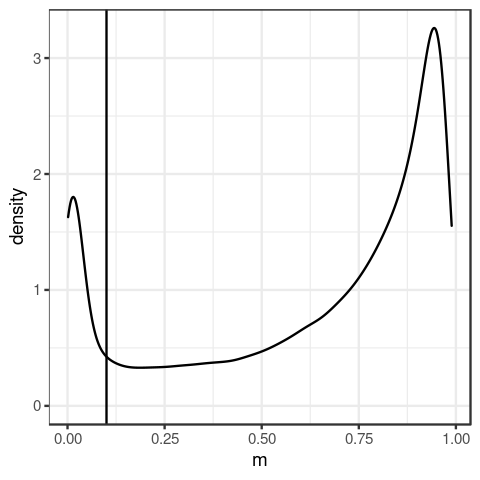

In [8]:
options(repr.plot.width = 4, repr.plot.height = 4)
tibble(m = means_ER_positive) %>% ggplot(aes(x=m))  + geom_density() + geom_vline(xintercept=meth_thresh) + theme_bw()

In [9]:
ER_positive_mat_s <- ER_positive_mat[means_ER_positive >= meth_thresh, ]
nrow(ER_positive_mat_s)

[1] 171026

We sample 50k loci and calculate a correlation matrix of their methylation values in ER+ samples:

In [10]:
set.seed(17)
ER_positive_mat_s <- ER_positive_mat_s[sample(1:nrow(ER_positive_mat_s), 5e4), ]

In [11]:
cm <- tgs_cor(t(ER_positive_mat_s), pairwise.complete.obs=TRUE) %cache_rds% here("data/ER_positive_loci_cm_samp.rds")

We remove rows and columns without at least one correlation value above 0.25:

In [12]:
cm1 <- cm
diag(cm1) <- NA
cor_maxs <- matrixStats::rowMaxs(abs(cm1), na.rm=TRUE)
f <- cor_maxs >= 0.25
cm_f <- cm[f, f] 

In [13]:
dim(cm_f)

[1] 45299 45299

We cluster the correlation matrix using `hclust`:

In [14]:
hc_meth <- as.dist(1-cm_f) %>% fastcluster::hclust(method = "ward.D2") %cache_rds% here("data/ER_positive_loci_cm_hclust.rds")

Reorder the dendrogram according to raw average methylation:

In [15]:
hc_meth <- vegan:::reorder.hclust(hc_meth, rowMeans(ER_positive_mat_raw[rownames(cm_f), ], na.rm=TRUE)) %cache_rds% here("data/ER_positive_loci_cm_hclust_reordered.rds")

We start by cutting the the tree with a large number of clusters (14) which we will then aim to merge.

In [16]:
k <- 14

#### Extended Data Figure 4a

downscaling matrix

downscale k: 22

plotting



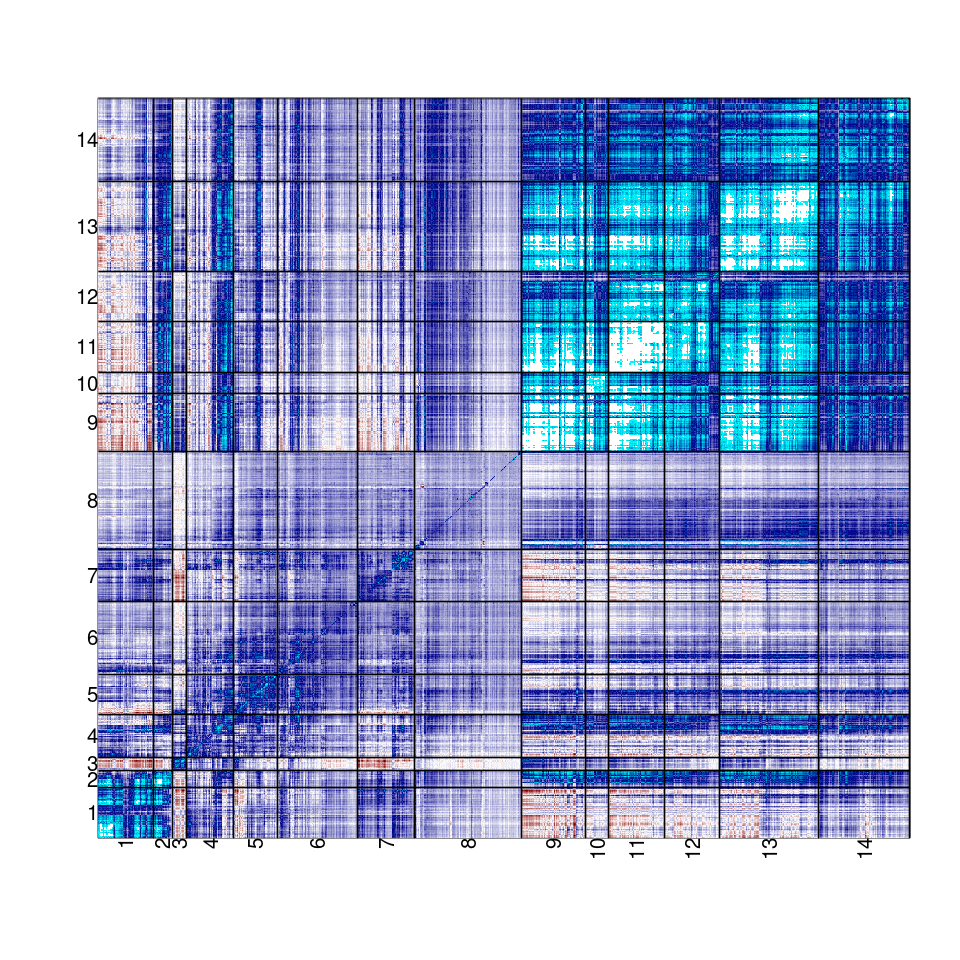

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_meth_mat_cm(cm_f, k=k, width = 1000, height = 1000, hc_meth=hc_meth, downscale = TRUE, zlim = c(-0.3, 0.3), colors = c("black", "darkred", "white", "darkblue", "cyan"))

We can see that there is a large group of correlated loci at the top right (9-14), another group in the middle (5), and another one at the bottom left (1-2). In addition, we have another 2 small clusters (3 and 7) which are anti-correlated to each other.

The other clusters (4,6,8) look weak in their intra correalation. 

We term the first large group "clock", the second "ML" and the last "MG" due to reasons that would be disscused at `clock` and `Epigenomic-instability` notebooks. 

In [18]:
ct <- cutree_order(hc_meth, k=k)
ct_new <- case_when(
    ct %in% 9:14 ~ "clock", 
    ct == 5 ~ "ML", 
    ct %in% 1:2 ~ "MG",
    ct == 3 ~ "other1",     
    ct == 7 ~ "other2", 
    TRUE ~ "no_cor")
names(ct_new) <- names(ct)

In [19]:
clust_df <- as.matrix(ct_new) %>% mat_to_intervs() %>% rename(clust = V1) %cache_df% here("data/ER_positive_loci_clust.tsv") %>% as_tibble()
clust_df %>% count(clust)

clust  n    
1 clock  21657
2 MG      4102
3 ML      2448
4 no_cor 13120
5 other1   821
6 other2  3151

We will generate a score for each tumor based on the mean methylation of each group:

In [20]:
feats_mat <- tgs_matrix_tapply(all_norm_meth %>% intervs_to_mat() %>% .[names(ct_new), ] %>% t(), ct_new, mean, na.rm=TRUE) %>% t()

We add the TME features for comparison:

In [21]:
tme_df <- fread(here("data/TME_features.tsv")) %>% as_tibble()
feats_mat <- cbind(feats_mat, tme_df  %>% select(samp, caf, immune, caf.meth, immune.meth) %>% as.data.frame() %>% column_to_rownames("samp"))

In [22]:
feats_df <- feats_mat %>% 
    as.data.frame() %>% 
    rownames_to_column("samp") %>%     
    select(-other1, -other2, -no_cor) %>%
    left_join(samp_data %>% select(samp, ER=ER1), by = "samp") %>%     
    select(samp, ER, everything()) %cache_df% 
    here("data/epigenomic_features.tsv") %>% 
    as_tibble()

In [23]:
head(feats_df)

samp    ER  clock        MG          ML           caf        immune    
1 MB_0006 ER+  0.020284548 -0.09092389 -0.006315781 -0.2441946 -0.1114837
2 MB_0028 ER+  0.134212088 -0.02794677 -0.011634957 -1.7266095 -0.9358944
3 MB_0046 ER+  0.017717551  0.01210391 -0.103759329 -0.6545081 -1.0023582
4 MB_0050 ER+  0.003517646 -0.05415309 -0.046344401  1.7038169  0.1281640
5 MB_0053 ER+ -0.029721111  0.01603443  0.075428738 -0.8152407  0.2103729
6 MB_0054 ER+  0.067999324  0.04493482 -0.001099083 -0.5608747  0.9292829
  caf.meth  immune.meth
1 0.2950609 0.4722494  
2 0.4851022 0.6191494  
3 0.4210078 0.6308352  
4 0.2336145 0.4808316  
5 0.4603347 0.5915159  
6 0.4790603 0.6093489

We save the the cluster association of each locus:

In [24]:
loci_clust <- as.matrix(ct_new) %>% mat_to_intervs() %>% rename(clust = V1) %cache_df% here("data/ER_positive_loci_clust_df.tsv") %>% as_tibble()

For the 3 large meta-clusters (clock, MG, ML) we calcualte the __raw__ (before TME normalization) average methylation in each sample:

In [25]:
loci_f <- loci_clust %>% filter(clust %in% c("clock", "MG", "ML")) %>% intervs_to_mat()

In [26]:
feats_mat_raw <- tgs_matrix_tapply(all_mat_raw[rownames(loci_f), ] %>% t(), loci_f[, 1], mean, na.rm=TRUE) %>% t() %>% as.data.frame() %>% rownames_to_column("samp")

In [27]:
feats_df_raw <- tme_df %>% 
    left_join(feats_mat_raw, by = "samp") %>% 
    add_ER() %>% 
    select(samp, ER, everything()) %fcache_df% 
    here("data/epigenomic_features_raw_meth.tsv") %>% 
    as_tibble()
head(feats_df_raw)

samp    ER  caf        immune     caf.meth  immune.meth clock     MG       
1 MB_0006 ER+ -0.2441946 -0.1114837 0.2950609 0.4722494   0.7843678 0.2557624
2 MB_0028 ER+ -1.7266095 -0.9358944 0.4851022 0.6191494   0.8746526 0.3684660
3 MB_0046 ER+ -0.6545081 -1.0023582 0.4210078 0.6308352   0.7931583 0.3512826
4 MB_0050 ER+  1.7038169  0.1281640 0.2336145 0.4808316   0.8128158 0.1990629
5 MB_0053 ER+ -0.8152407  0.2103729 0.4603347 0.5915159   0.7309033 0.3691415
6 MB_0054 ER+ -0.5608747  0.9292829 0.4790603 0.6093489   0.8237875 0.3819997
  ML       
1 0.7020038
2 0.7049314
3 0.5910172
4 0.6801434
5 0.7798542
6 0.6909709

## Project clustering on ER- correlation matrix

In [28]:
ER_negative_mat <- all_norm_meth %>% select(chrom:end, any_of(ER_negative_samples)) %>% intervs_to_mat()

In [29]:
ER_negative_mat_f <- ER_negative_mat[rownames(cm_f), ]

In [30]:
dim(ER_negative_mat_f)

[1] 45299   310

In [31]:
cm_f_neg <- tgs_cor(t(ER_negative_mat_f), pairwise.complete.obs=TRUE) %cache_rds% here("data/ER_negative_loci_cm_samp.rds")

#### Extended Data Figure 4b

downscaling matrix

downscale k: 22

plotting



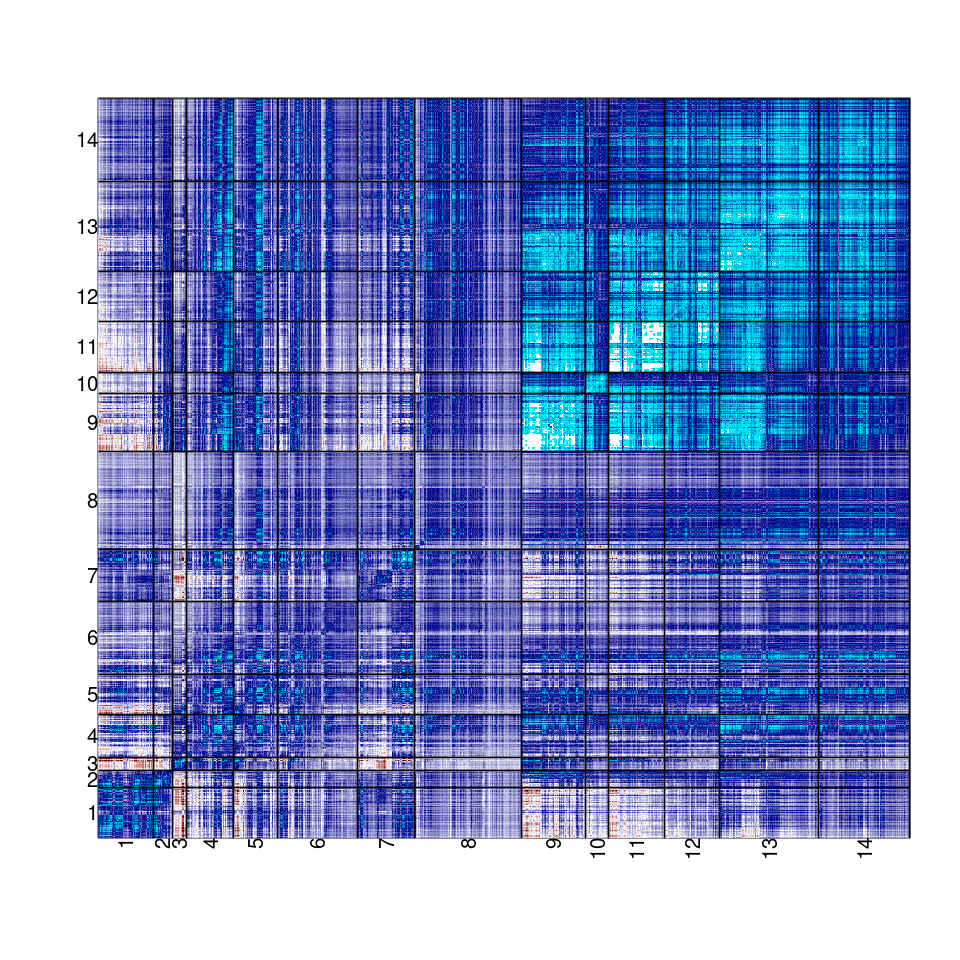

In [32]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_meth_mat_cm(cm_f_neg, k=k, width = 1000, height = 1000, hc_meth=hc_meth, downscale = TRUE, zlim = c(-0.3, 0.3), colors = c("black", "darkred", "white", "darkblue", "cyan"))

We can see that the clock, MG and ML are preserved also in ER- tumors. 

## Classify loci in the genome to epigenomic features

See `Loss-clock` and `Epignomic-instability` notebooks for further characterization of the epigenomic scores. We would now continue to look at the broad genomic picture and try to classify loci in the genome based on their correlation with the scores. 

In [35]:
# calculate the correlation between normalized methylation and the epigenomic features
epi_features_loci_cors <- function(all_norm_meth, feats_df, samples){
    samples <- intersect(samples, feats_df$samp)
    samples <- intersect(samples, colnames(all_norm_meth)[-(1:3)])
    mat <- all_norm_meth %>% select(chrom:end, any_of(samples)) %>% intervs_to_mat()
    feats_mat <- feats_df %>% select(-ER) %>% as.data.frame() %>% column_to_rownames("samp") %>% as.matrix()
    
    loci_cors <- tgs_cor(t(mat[, samples]), feats_mat[samples, ], pairwise.complete.obs = TRUE)
    loci_cors <- loci_cors %>% mat_to_intervs()
    return(loci_cors)    
}

In [36]:
loci_cors <- bind_rows(
        epi_features_loci_cors(all_norm_meth, feats_df, ER_positive_samples) %>% mutate(ER = "ER+"), 
        epi_features_loci_cors(all_norm_meth, feats_df, ER_negative_samples) %>% mutate(ER = "ER-"), 
        epi_features_loci_cors(all_norm_meth, feats_df, normal_samples) %>% mutate(ER = "normal")
    ) %>% 
    select(chrom:end, ER, everything()) %fcache_df%
    here("data/features_loci_cors.tsv") %>% 
    as_tibble()    

Looking at all the correaltions we see that there are loci who are not correlated to any of the featurers:

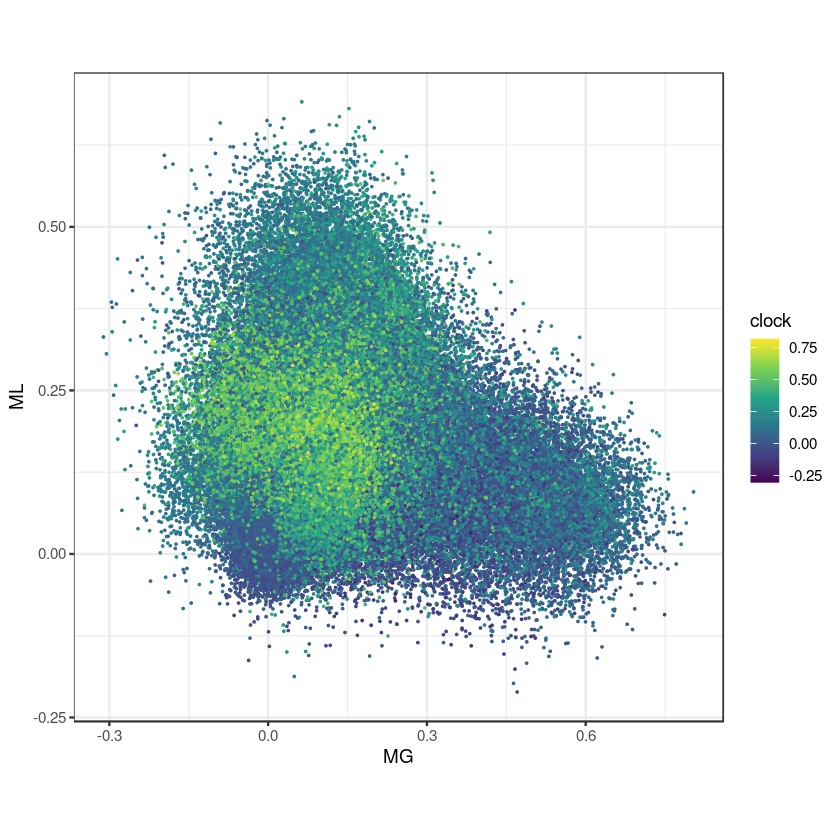

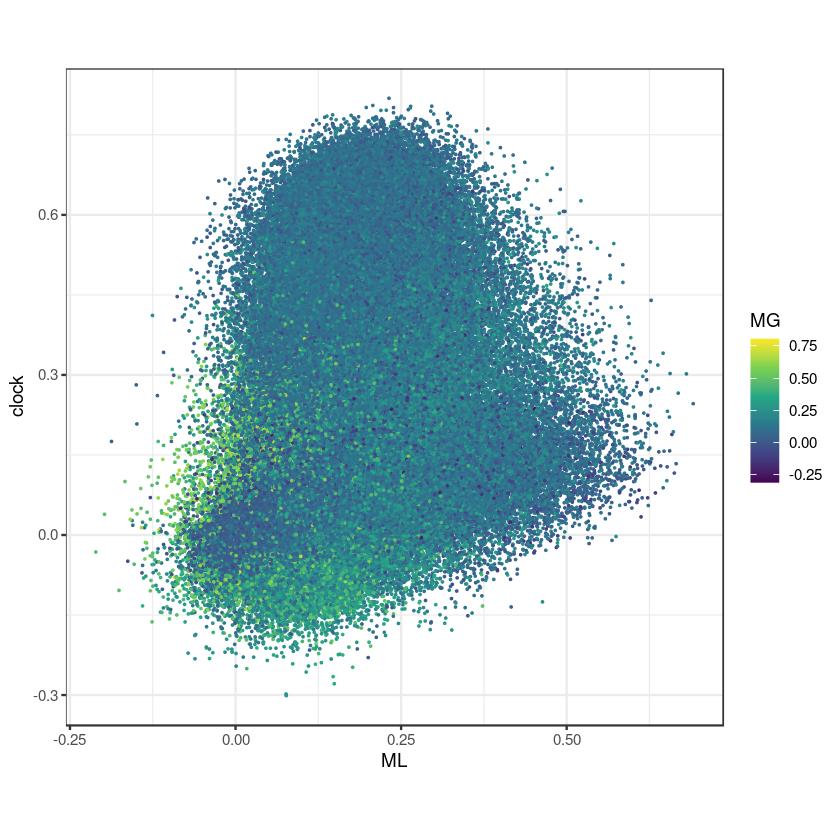

In [37]:
options(repr.plot.width = 7, repr.plot.height = 7)
loci_cors %>% filter(ER == "ER+") %>% ggplot(aes(x=MG, y=ML, color=clock)) + geom_point(size=0.0001) + theme_bw() + theme(aspect.ratio=1) + scale_color_viridis_c()
loci_cors %>% filter(ER == "ER+") %>% ggplot(aes(x=ML, y=clock, color=MG)) + geom_point(size=0.0001) + theme_bw() + theme(aspect.ratio=1) + scale_color_viridis_c()

We use PCA (pricinpal component analysis) on the features for visualization of the feature space

In [38]:
loci_cors %>% distinct(chrom, start, end) %>% nrow()

[1] 201082

In [39]:
pca <- loci_cors %>% filter(ER == "ER+") %>% select(-ER, -immune, -caf) %>% intervs_to_mat() %>% t() %>% prcomp()

In [40]:
df <- pca$rotation %>% mat_to_intervs() %>% left_join(loci_cors %>% filter(ER == "ER+"), by = c("chrom", "start", "end")) %>% as_tibble()

#### Figure 2a

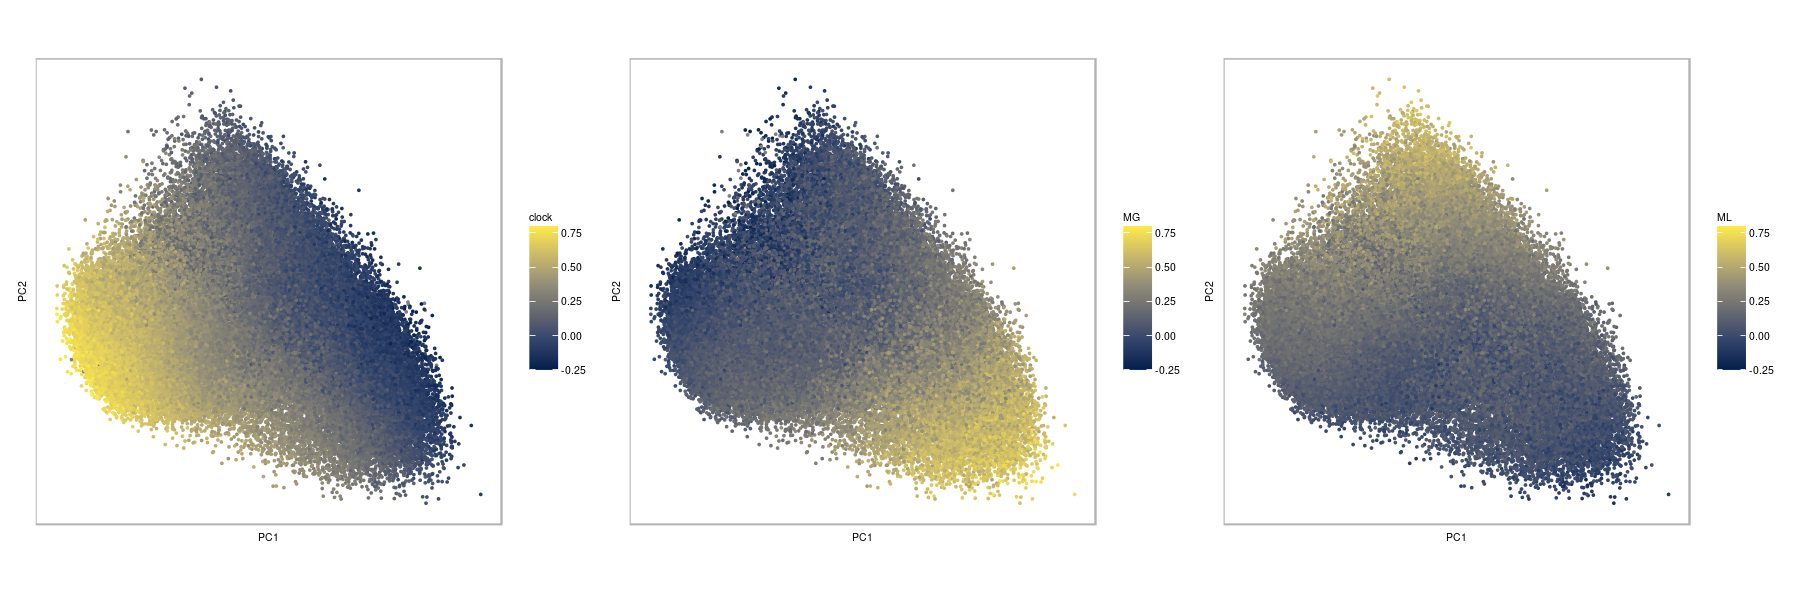

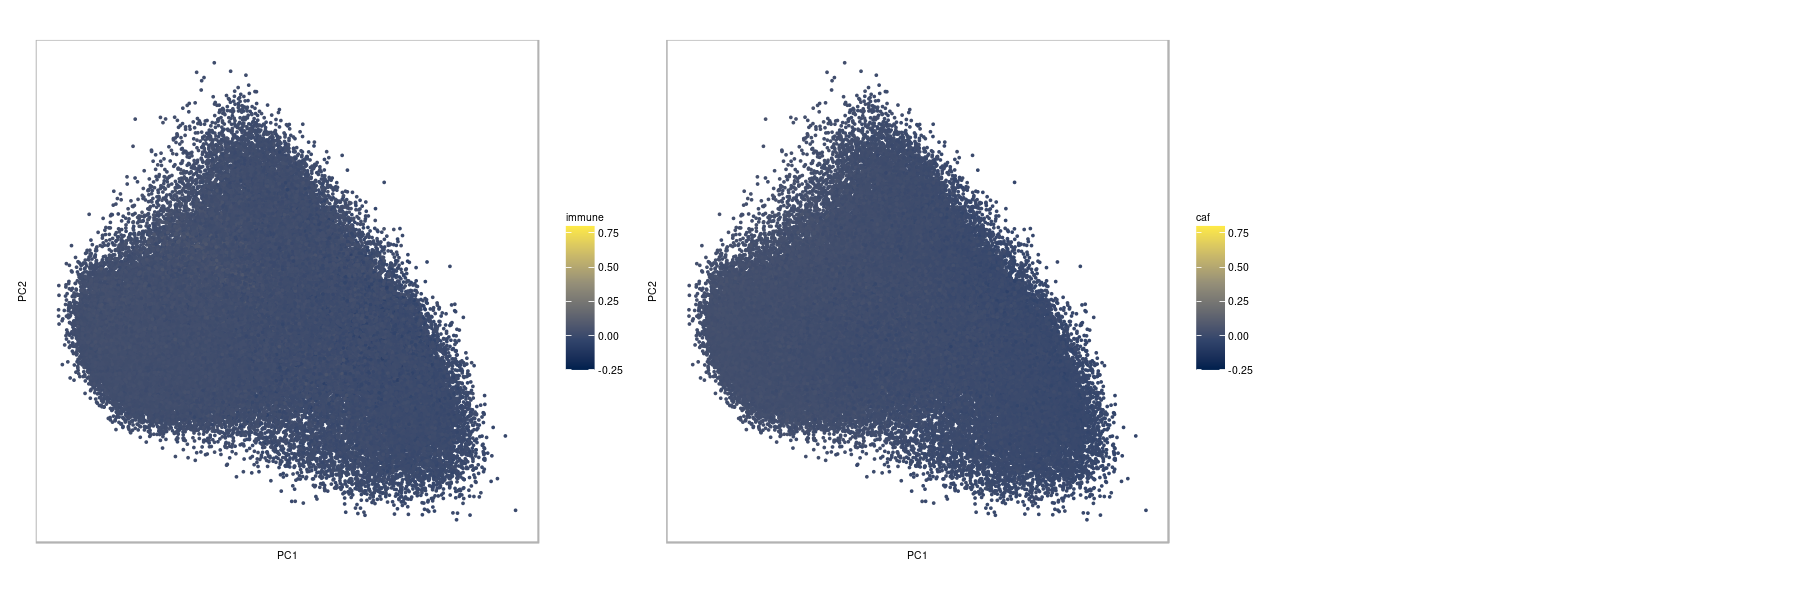

In [41]:
options(repr.plot.width = 15, repr.plot.height = 5)

remove_axis <- function(x)
        theme( aspect.ratio = 1,
            strip.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.ticks = element_blank(),
            axis.text = element_blank()
        )
point_size = 1e-10
viridis_opt <- "E"
limits <- c(-0.25, 0.8)
p_clock_proj <- df %>% ggplot(aes(x=PC1, y=PC2, color=clock)) + geom_point(size=point_size)   + remove_axis() + scale_color_viridis_c(option = viridis_opt, limits = limits)
p_MG_proj <- df %>% ggplot(aes(x=PC1, y=PC2, color=MG)) + geom_point(size=point_size)   + remove_axis() + scale_color_viridis_c(option = viridis_opt, limits = limits)
p_ML_proj <- df %>% ggplot(aes(x=PC1, y=PC2, color=ML)) + geom_point(size=point_size)   + remove_axis() + scale_color_viridis_c(option = viridis_opt, limits = limits)
p_immune_proj <- df %>% ggplot(aes(x=PC1, y=PC2, color=immune)) + geom_point(size=point_size) + remove_axis() + scale_color_viridis_c(option = viridis_opt, limits = limits)
p_caf_proj <- df %>% ggplot(aes(x=PC1, y=PC2, color=caf)) + geom_point(size=point_size)  + remove_axis() + scale_color_viridis_c(option = viridis_opt, limits = limits)

(p_clock_proj + p_MG_proj + p_ML_proj) 
(p_immune_proj + p_caf_proj + plot_spacer())

## Average methylation of the features

We will now move to look at the average methylation distribution of the scores. We will do that computing the average methylation (in ER+/ER-/normal) of loci that are highly correlated to them (above 0.6 for clock and above 0.5 for MG and ML). 

In [54]:
loci_annot <- loci_cors %>% 
    filter(ER == "ER+") %>% 
    select(-ER) %>% 
    left_join(get_loci_annot(), by = c("chrom", "start", "end")) %cache_df%
    here("data/loci_annot_epigenomic_features.tsv") %>% 
    as_tibble()
head(loci_annot)

chrom start  end    clock        MG          ML          caf         
1 chr1  762469 763020  0.001575984 -0.01428874 -0.01551105  0.012110476
2 chr1  762676 763227 -0.129625330  0.33612856  0.03607766 -0.006588455
3 chr1  860619 861170 -0.050509334  0.29208240  0.14625292 -0.008582681
4 chr1  895465 896016  0.068537024  0.34194079  0.04775239  0.007077953
5 chr1  901375 901926  0.092230378  0.05256030  0.07306855  0.004076673
6 chr1  948345 948896  0.019768875  0.02448860  0.03588616 -0.003594507
  immune        caf.meth    immune.meth cg_cont    tor      tss_d k27me3   
1 -0.0038356268 -0.01015590  0.01583110 0.10130379 64.78630  158  0.9678000
2 -0.0051811514  0.27247376  0.13967267 0.12012641 64.80790  -48  0.9832893
3  0.0122705825  0.21490060  0.09494949 0.12763213 74.13830 -226  0.9983592
4  0.0037199954  0.25625416  0.17188417 0.09146498 78.45700 -226  0.9882345
5  0.0119557122  0.01421310 -0.01829405 0.05323296 79.12555 -226  0.9923163
6  0.0001512059  0.01424724  0.02610006 0.03862698 82.83044 -226  0.8459000
  k4me1_luminal k4me1_myo1 k4me1_myo2 k4me1_hmec
1 0.5759000     0.8639     0.6325000  0.8790000 
2 0.5759000     0.8639     0.7695000  0.8871000 
3 0.9742000     0.9781     0.9804800  0.9547000 
4 0.9742000     0.9603     0.9639000  0.9397000 
5 0.9995784     0.9781     0.9962854  0.9994769 
6 0.9940496     0.9704     0.9578000  0.9647000

See exons-TME notebook for the generation of this file. 

In [59]:
loci_annot_exons <- fread(here("data/exon_annot_epigenomic_features.tsv")) %>% as_tibble()

## Plot distribution over samples of the correlated loci

We calculate the average methylation of each sample in loci that pass the threshold of every score: 

In [61]:
df_MG <- colMeans(all_mat_raw[loci_annot %>% filter(MG >= 0.5) %>% intervs_to_mat() %>% rownames(), ], na.rm=TRUE) %>% enframe("samp", "MG")
df_ML <- colMeans(all_mat_raw[loci_annot %>% filter(ML >= 0.5) %>% intervs_to_mat() %>% rownames(), ], na.rm=TRUE) %>% enframe("samp", "ML")
df_clock <- colMeans(all_mat_raw[loci_annot %>% filter(clock >= 0.5) %>% intervs_to_mat() %>% rownames(), ], na.rm=TRUE) %>% enframe("samp", "clock")
df_sum <- df_clock %>% 
    left_join(df_MG, by = "samp") %>% 
    left_join(df_ML, by = "samp") %>% 
    add_ER() %>% 
    filter(!is.na(ER))

We can now plot the distribution of scores over samples: 

#### Figure 1i

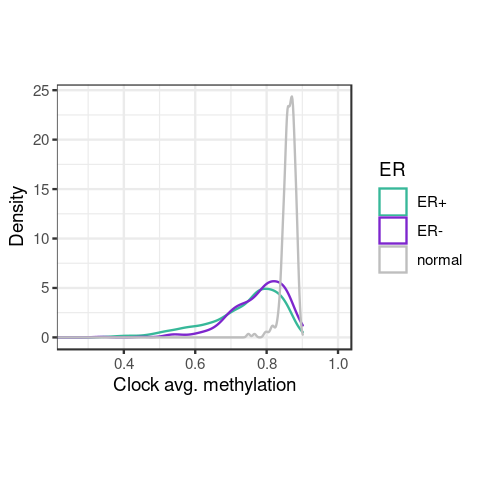

In [62]:
options(repr.plot.width = 4, repr.plot.height = 4)
p_avg_clock <- df_sum %>%     
    ggplot(aes(x=clock, color=ER)) + 
        geom_density() + 
        scale_color_manual(values = annot_colors$ER1) + 
        theme(aspect.ratio = 1) + 
        ylab("Density") + 
        xlab("Clock avg. methylation") + 
        coord_cartesian(xlim=c(0.25, 1))

p_avg_clock + theme_bw() + theme(aspect.ratio = 0.9)    

#### Figure 2b

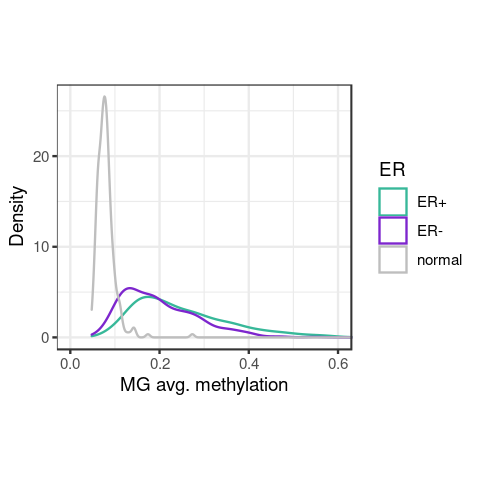

In [63]:
options(repr.plot.width = 4, repr.plot.height = 4)
p_avg_MG <- df_sum %>%     
    ggplot(aes(x=MG, color=ER)) + 
        geom_density() + 
        scale_color_manual(values = annot_colors$ER1) + 
        theme(aspect.ratio = 1) + 
        ylab("Density") + 
        xlab("MG avg. methylation") + 
        coord_cartesian(xlim=c(0, 0.6))

p_avg_MG + theme_bw() + theme(aspect.ratio = 0.9)    

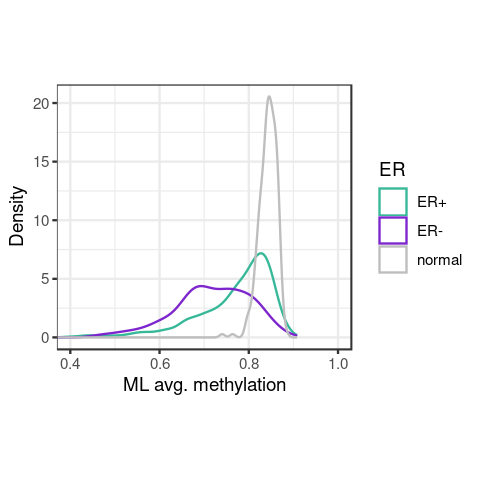

In [64]:
options(repr.plot.width = 4, repr.plot.height = 4)
p_avg_ML <- df_sum %>%     
    ggplot(aes(x=ML, color=ER)) + 
        geom_density() + 
        scale_color_manual(values = annot_colors$ER1) + 
        theme(aspect.ratio = 1) + 
        ylab("Density") + 
        xlab("ML avg. methylation") + 
        coord_cartesian(xlim=c(0.4, 1))

p_avg_ML + theme_bw() + theme(aspect.ratio = 0.9)    

Calculate p-values:

In [65]:
df_sum %>% 
    gather("feat", "meth", -samp, -ER) %>% 
    group_by(feat) %>% 
    summarise(
        p_pos_norm = ks.test(meth[ER == "ER+"], meth[ER == "normal"])$p.value, 
        p_neg_norm = ks.test(meth[ER == "ER-"], meth[ER == "normal"])$p.value)

feat  p_pos_norm p_neg_norm
1 clock 0          0         
2 MG    0          0         
3 ML    0          0

## Plot loci classification

Next, we classify loci to "Promoters", "Enhancers" or "Background" (non promoter/enhancer), and stratify by CpG content.

In [72]:
df_loci_class <- loci_annot %>% 
        left_join(promoter_intervs %>% distinct(chrom, start, end) %>% mutate(type = "Promoters"), by = c("chrom", "start", "end")) 

k4me1_names <- grep("k4me1", colnames(loci_annot), value=TRUE)
df_loci_class <- df_loci_class %>%            
    mutate(type = 
        case_when(            
            type == "Promoters" ~ "Promoters",
            matrixStats::rowAnys((df_loci_class[, k4me1_names] > 0.97), na.rm = TRUE) ~ "Enhancers", 
            TRUE ~ "Background"
        )
    ) %>%                           
    bind_rows(loci_annot_exons %>% mutate(type = "Exons")) %>%
    mutate(cg_cont = cut(cg_cont, c(0,0.04,0.08,1), include.lowest=TRUE, labels=c("Low", "Mid", "High"))) %>%
    as_tibble()

In [73]:
df_loci_layer <- df_loci_class %>% left_join(get_all_summary_meth(), by = c("chrom", "start", "end")) %>% mutate(normal_type = cut(normal, breaks = c(0, 0.2, 0.9, 1), labels = c("0-0.2", "0.2-0.9", "0.9-1"), include.lowest=TRUE))

In [74]:
cor_thresh <- 0.25

df_loci_layer <- df_loci_layer %>% 
    mutate(layer = case_when(clock >= cor_thresh ~ "clock", MG >= cor_thresh ~ "MG", ML >= cor_thresh ~ "ML", TRUE ~ "other"), layer = factor(layer, levels = c("other", "clock", "ML", "MG")))

In [75]:
df_loci_layer %>% count(type, layer)  %>% as.data.frame()

type       layer n    
1  Background other 54248
2  Background clock 74369
3  Background ML    11758
4  Background MG     7044
5  Enhancers  other 16628
6  Enhancers  clock  5642
7  Enhancers  ML     5299
8  Enhancers  MG    10401
9  Exons      other 17923
10 Exons      clock  5146
11 Exons      ML     1944
12 Exons      MG     4499
13 Promoters  other 11539
14 Promoters  clock   780
15 Promoters  ML      379
16 Promoters  MG     2995

In [76]:
df_loci_layer %>% filter(type == "Enhancers", cg_cont %in% c("Mid", "High")) %>% count(layer)  %>% mutate(p = n / sum(n)) %>% as.data.frame()

layer n    p         
1 other 7076 0.41197019
2 clock 1260 0.07335817
3 ML    1117 0.06503260
4 MG    7723 0.44963903

In [77]:
df_loci_layer %>% 
    filter(type == "Enhancers") %>% 
    count(normal_type, layer) %>% 
    group_by(normal_type) %>% 
    mutate(p = n / sum(n)) %>% 
    as.data.frame()

normal_type layer n    p          
1  0-0.2       other 7141 0.471228718
2  0-0.2       clock  573 0.037811799
3  0-0.2       ML     184 0.012142009
4  0-0.2       MG    7256 0.478817474
5  0.2-0.9     other 7208 0.393965894
6  0.2-0.9     clock 3933 0.214965020
7  0.2-0.9     ML    4021 0.219774814
8  0.2-0.9     MG    3134 0.171294272
9  0.9-1       other 2279 0.504203540
10 0.9-1       clock 1136 0.251327434
11 0.9-1       ML    1094 0.242035398
12 0.9-1       MG      11 0.002433628

#### Figure 2c

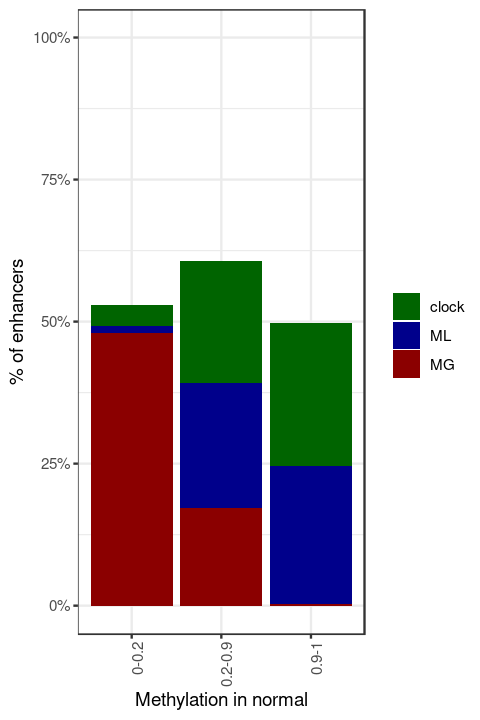

In [78]:
options(repr.plot.width = 4, repr.plot.height = 6)
df <- df_loci_layer %>% 
    filter(type == "Enhancers") %>% 
    count(normal_type, layer) %>% 
    group_by(normal_type) %>% 
    mutate(p = n / sum(n))

p_enh_layer_perc <- df %>% 
    filter(layer != "other") %>% 
    ggplot(aes(x=normal_type, y=p, fill=layer)) + 
        geom_col() + 
        scale_fill_manual(name = "", values = c("ML" = "darkblue", "MG" = "darkred", "clock" = "darkgreen")) + 
        scale_y_continuous(limits = c(0,1), labels=scales::percent) + 
        vertical_labs() +         
        xlab("Methylation in normal") + 
        ylab("% of enhancers")

p_enh_layer_perc + theme_bw() + vertical_labs()

#### Extended Data Figure 6c

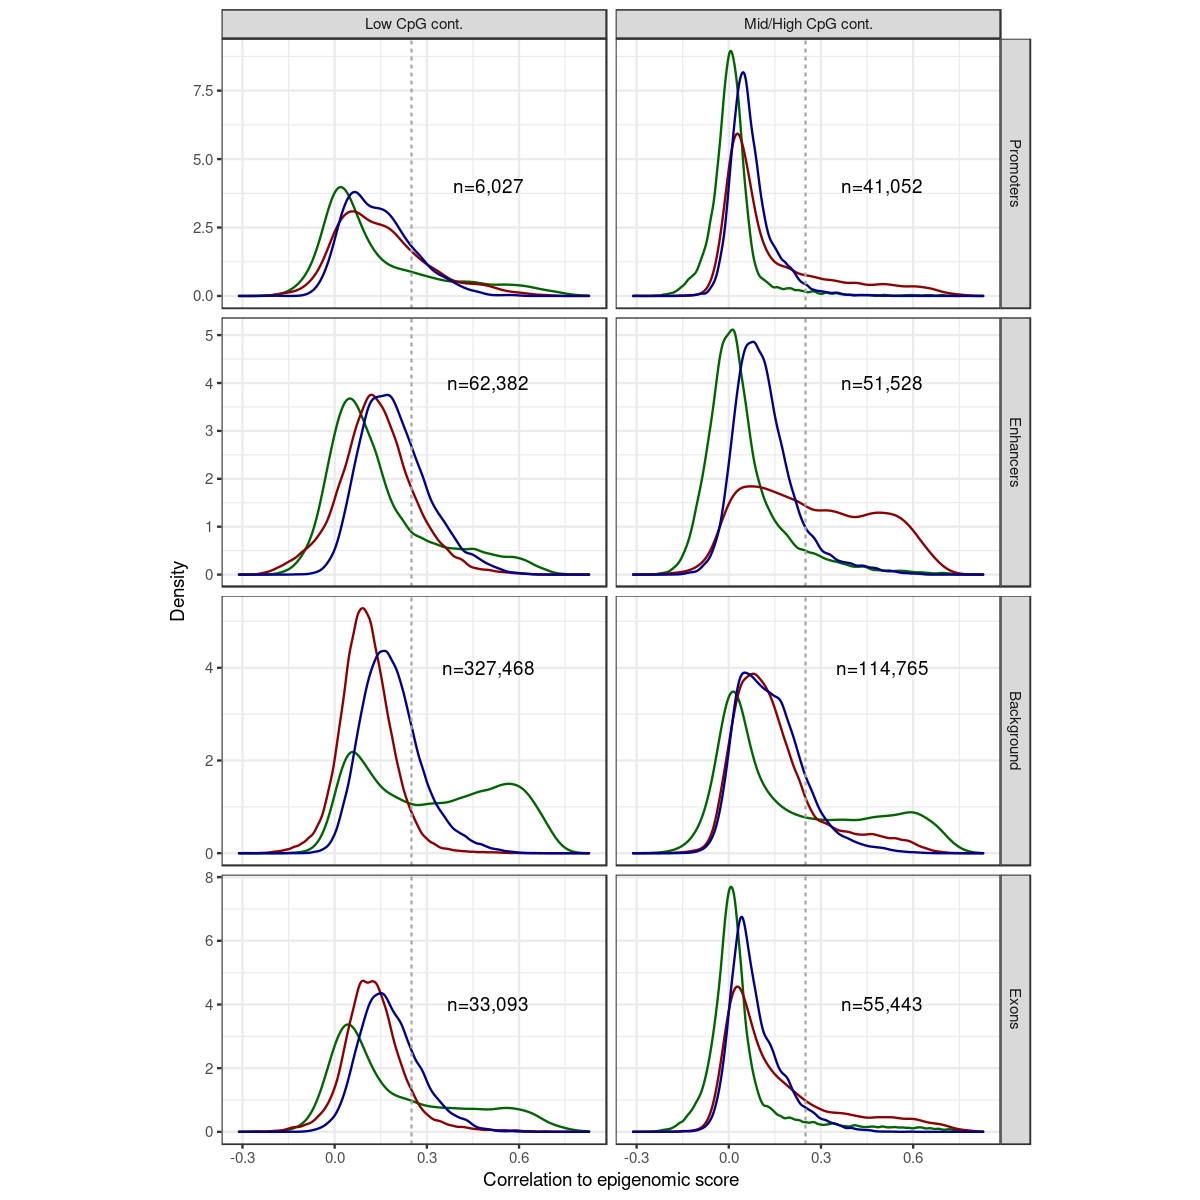

In [79]:
options(repr.plot.width = 10, repr.plot.height = 10)
df <- df_loci_class %>% 
    filter(!is.na(cg_cont)) %>% 
    mutate(cg_cont = case_when(cg_cont == "Low" ~ "Low", cg_cont %in% c("Mid", "High") ~ "Mid/High")) %>% 
    mutate(
        cg_cont = paste(cg_cont, "CpG cont."), 
        cg_cont = factor(cg_cont, levels=c("Low CpG cont.", "Mid/High CpG cont.")), 
        type = factor(type, levels=c("Promoters", "Enhancers", "Background", "Exons"))) %>% 
    select(chrom, start, end, type, cg_cont, clock, MG, ML) %>% 
    gather("class", "cor", -(chrom:end), -cg_cont, -type)

p_cor_density <- df %>% 
    ggplot(aes(x=cor, color=class)) + 
        geom_density(size=0.5) + 
        scale_color_manual(name = "", values = c("ML" = "darkblue", "MG" = "darkred", "clock" = "darkgreen")) +
        guides(color=FALSE) + 
        ylab("Density") + 
        xlab("Correlation to epigenomic score") + 
        facet_grid(type~cg_cont, scales="free_y") +
        theme(aspect.ratio=0.5) + 
        geom_vline(xintercept = cor_thresh, linetype = "dashed", color="darkgray") + 
        geom_text(data = df %>% count(type, cg_cont) %>% mutate(label = paste0("n=", scales::comma(n))), inherit.aes = FALSE, aes(label=label), x = 0.5, y = 4)

p_cor_density + theme_bw() + theme(aspect.ratio=0.7)

## Project all epigenomic features using UMAP

In [72]:
set.seed(17)
raw_feats <- fread(here("data/epigenomic_features_raw_meth.tsv"))
um <- raw_feats %>%     
        mutate(ML = -ML, clock = -clock, immune.meth = -immune.meth, caf.meth = -caf.meth) %>%
        mutate(caf = caf / 20, immune = immune / 20) %>%  
        select(caf, immune, clock, MG, ML) %>%        
        as.matrix() %>%
        umap::umap()

In [73]:
mut_df <- fread(here("data/mutations.tsv")) %>% as_tibble()
p53_df <- mut_df %>%
        left_join(samp_data %>% select(samp, ER = ER1), by = "samp") %>%
        filter(gene == "TP53") %>%        
        mutate(p53= forcats::fct_recode(mutation, "WT" = "NO MUT", "TP53+" = "MUT+", "TP53-" = "MUT-")) %>%    
        select(samp, p53)

pik3ca_df <- mut_df %>%
        left_join(samp_data %>% select(samp, ER = ER1), by = "samp") %>%
        filter(gene == "PIK3CA") %>%        
        mutate(pik3ca = forcats::fct_recode(mutation, "WT" = "NO MUT", "PIK3CA+" = "MUT+", "PIK3CA-" = "MUT-")) %>%               select(samp, pik3ca)

Warning message:
“Unknown levels in `f`: MUT+”


In [75]:
feats_proj <- raw_feats %>%     
        mutate(ML = -ML, clock = -clock, immune.meth = -immune.meth, caf.meth = -caf.meth) %>%
        mutate(x = um$layout[, 1], y = um$layout[, 2]) %>%
        left_join(samp_data %>% select(samp, iC10, stage, grade, PAM50, gi = giScore_width, MathScore, epi_burden = log10_global_epm), by = "samp") %>%
        mutate(iC10 = factor(iC10, levels = names(annot_colors$iC10))) %>%
        mutate(stage = factor(stage, levels = names(annot_colors$stage))) %>%
        mutate(grade = factor(grade, levels = names(annot_colors$grade))) %>%
        mutate(PAM50 = factor(PAM50, levels = names(annot_colors$PAM50))) %>%
        left_join(p53_df, by = "samp") %>%
        mutate(p53 = forcats::fct_explicit_na(p53)) %>%
        left_join(pik3ca_df, by = "samp") %>% 
        mutate(pik3ca = forcats::fct_explicit_na(pik3ca)) %>% 
        mutate(grade = ifelse(ER == "normal", "ADJNORMAL", grade)) %>% 
        mutate(stage = ifelse(ER == "normal", "ADJNORMAL", stage))

#### Figure 4a.

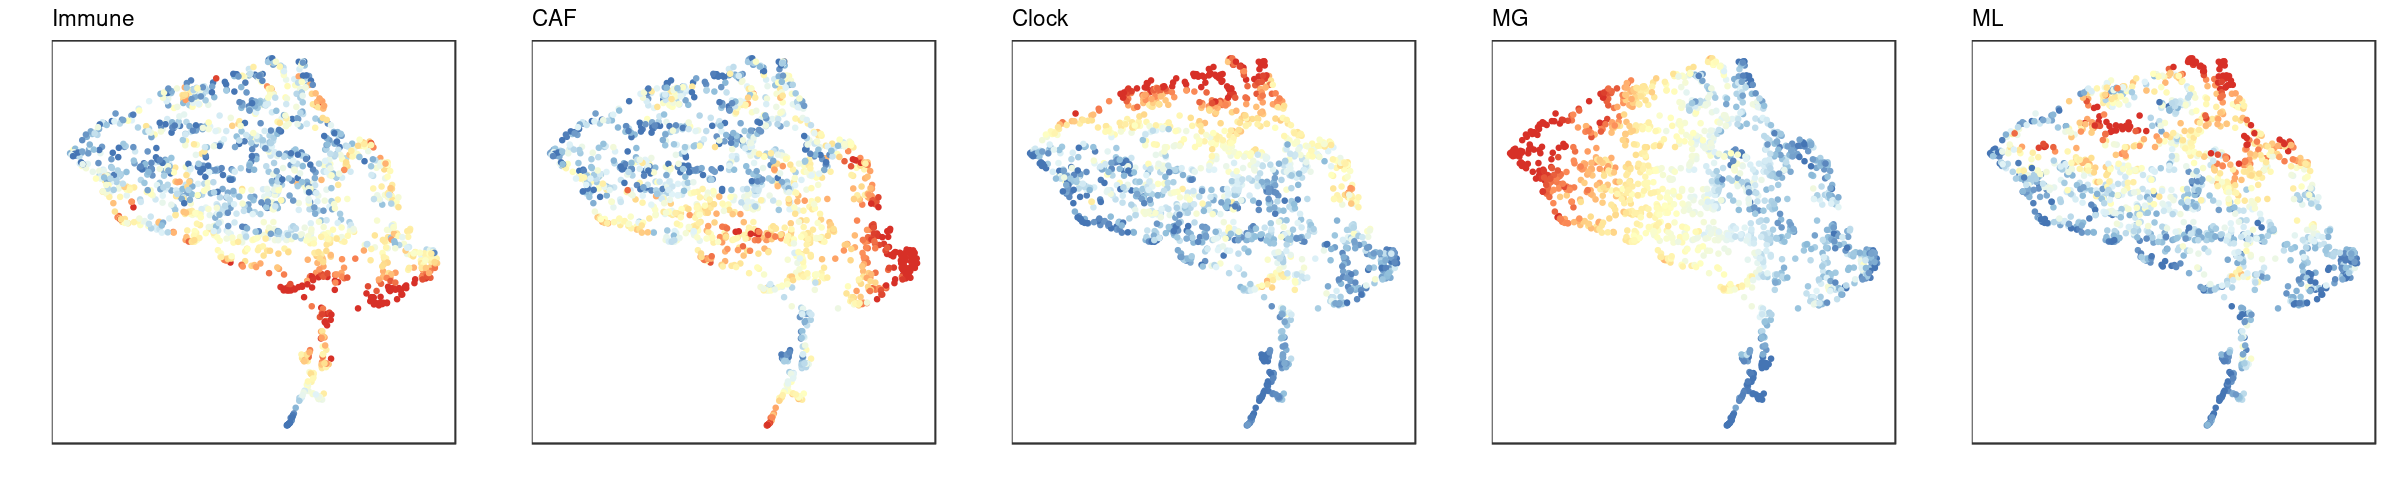

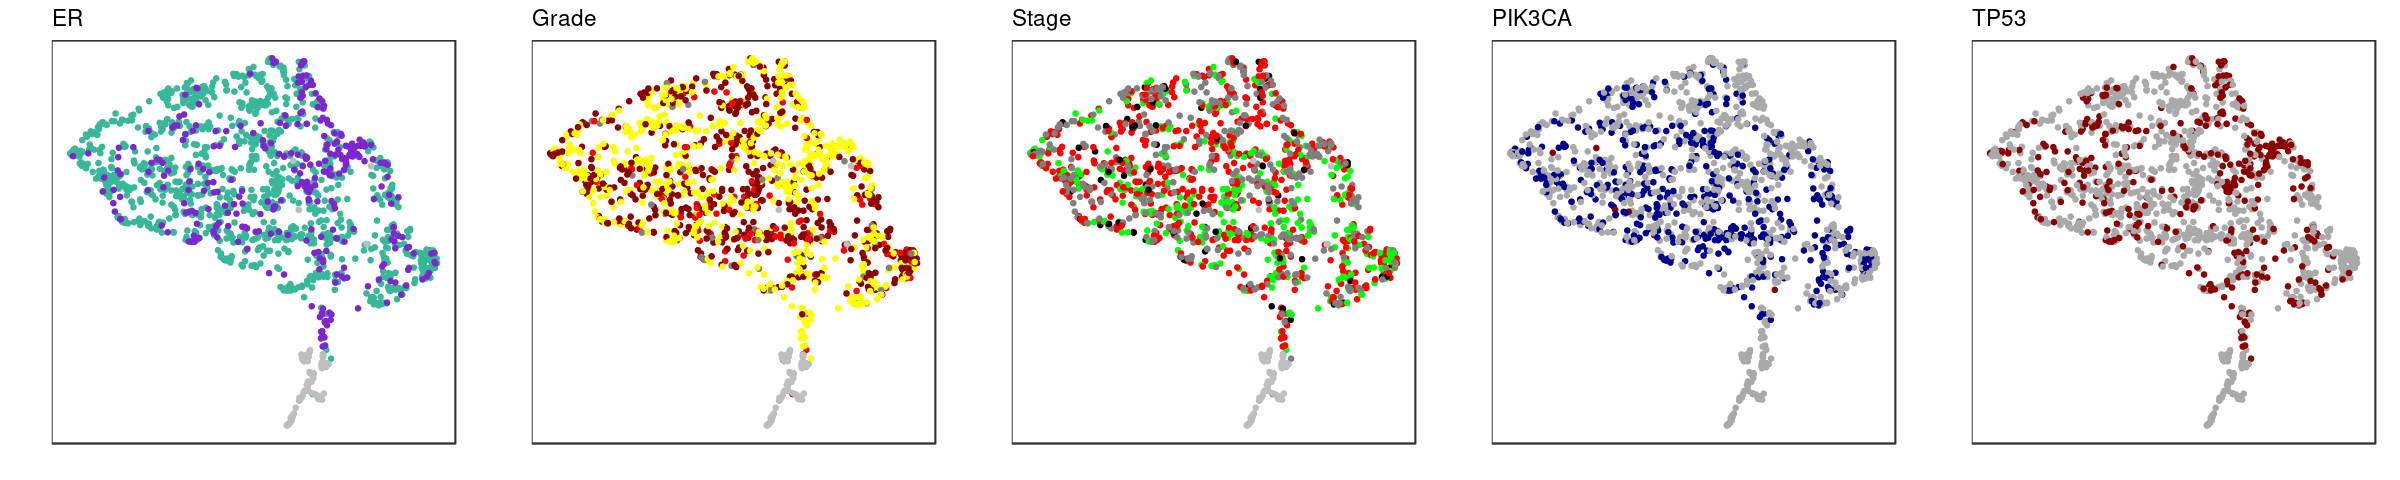

In [77]:
options(repr.plot.width = 20, repr.plot.height = 4)
plotlist <- list()
plotlist$ER <- feats_proj %>%
    ggplot(aes(x = x, y = y, color = ER)) +
    scale_color_manual(values = annot_colors$ER1)

plotlist$iC10 <- feats_proj %>%
    ggplot(aes(x = x, y = y, color = iC10)) +
    scale_color_manual(values = annot_colors$iC10)

plotlist$PAM50 <- feats_proj %>%
    ggplot(aes(x = x, y = y, color = PAM50)) +
    scale_color_manual(values = annot_colors$PAM50)

plotlist$grade <- feats_proj %>%
    ggplot(aes(x = x, y = y, color = grade)) +
    scale_color_manual(values = annot_colors$grade)

plotlist$stage <- feats_proj %>%
    ggplot(aes(x = x, y = y, color = stage)) +
    scale_color_manual(values = annot_colors$stage)

for (feat in c("immune", "caf", "clock", "MG", "ML", "gi", "MathScore", "epi_burden")) {
    df <- feats_proj
    df[[feat]] <- clip_vals(df[[feat]], quantile(df[[feat]], 0.05, na.rm = TRUE), quantile(df[[feat]], 0.95, na.rm = TRUE))
    plotlist[[feat]] <- df %>%
        ggplot(aes_string(x = "x", y = "y", color = feat)) +
        scale_colour_distiller(palette = "RdYlBu")
}

plotlist$p53 <- feats_proj %>%
    ggplot(aes(x = x, y = y, color = p53)) +
    scale_color_manual(values = c("TP53+" = "darkred", "TP53-" = "darkred", "WT" = "darkgray", "(Missing)" = "darkgray"))
plotlist$pik3ca <- feats_proj %>%
    ggplot(aes(x = x, y = y, color = pik3ca)) +
    scale_color_manual(values = c("PIK3CA-" = "darkred", "PIK3CA+" = "darkblue", "WT" = "darkgray", "(Missing)" = "darkgray"))

plotlist1 <- map(plotlist, ~
.x +
    xlab("") +
    ylab("") +
    theme(
        aspect.ratio = 1,
        strip.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.ticks = element_blank(),
        axis.text = element_blank()
    ))

p <- plot_grid(plotlist = map(plotlist1, ~ .x + geom_point(size = 0.8)))

plots_ppt1 <- map2(
        plotlist[c("immune", "caf", "clock", "MG", "ML")],
        c("Immune", "CAF", "Clock", "MG", "ML"),
        ~ .x + geom_point(size = 0.05) + guides(color = "none") + ggtitle(.y)
    )

plots_ppt2 <- map2(
        plotlist[c("ER", "grade", "stage", "pik3ca", "p53")],
        c("ER", "Grade", "Stage", "PIK3CA", "TP53"),
        ~ .x + geom_point(size = 0.05) + guides(color = "none") + ggtitle(.y)
)

plot_grid(plotlist = map(plots_ppt1, ~ .x + theme_bw() + theme(aspect.ratio = 1, strip.background = element_blank(),        panel.grid.major = element_blank(), panel.grid.minor = element_blank(), axis.ticks = element_blank(), axis.text = element_blank()) + xlab("") + ylab("") + geom_point(size = 0.8)), nrow=1)

plot_grid(plotlist = map(plots_ppt2, ~ .x + theme_bw() + theme(aspect.ratio = 1, strip.background = element_blank(),        panel.grid.major = element_blank(), panel.grid.minor = element_blank(), axis.ticks = element_blank(), axis.text = element_blank()) + xlab("") + ylab("") + geom_point(size = 0.8)), nrow=1)

## Compare epigenomic scores to clinical annotations

In [78]:
all_feats <- fread(here("data/epigenomic_features.tsv")) %>% mutate(ML = -ML, clock = -clock, immune.meth = -immune.meth, caf.meth = -caf.meth) %>% as_tibble()

In [80]:
feats_tidy <- all_feats %>% 
        select(-caf, -immune) %>% 
        rename(caf = caf.meth, immune = immune.meth) %>% 
        gather("feat", "score", -ER, -samp) 

#### Figure 4c, Extended Data Figure 10b

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


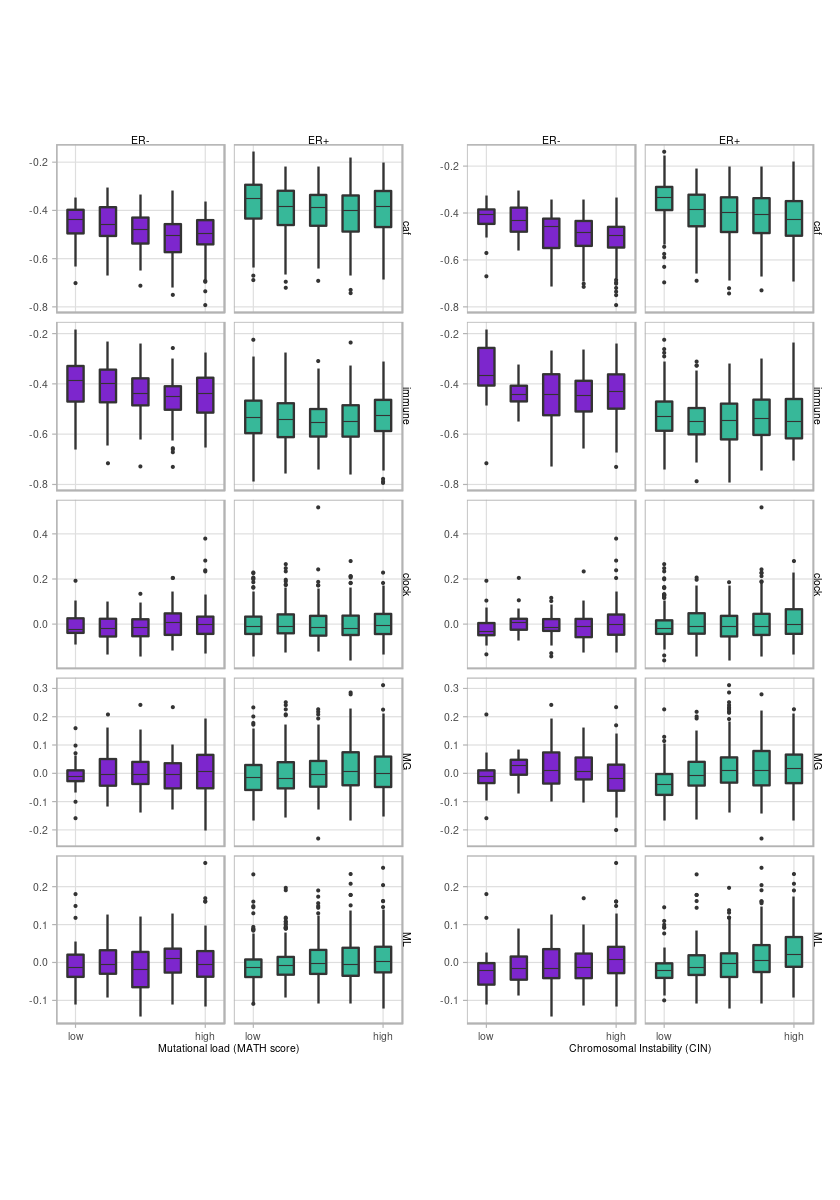

In [85]:
options(repr.plot.width = 7, repr.plot.height = 10)

p_mut <- plot_score_feats_boxp(samp_data %>% select(samp, clin_feat = MathScore), "Mutational load (MATH score)
", feats_tidy, nbins = 5)
p_gi <- plot_score_feats_boxp(samp_data %>% select(samp, clin_feat = giScore_width), "Chromosomal Instability (CIN)", feats_tidy, nbins = 5) 

p_mut + p_gi 

p.values 

In [86]:
feats_tidy %>% left_join(samp_data %>% select(samp, clin_feat = MathScore)) %>% group_by(ER, feat) %>% na.omit() %>% do({broom::tidy(cor.test(.$score, .$clin_feat, method = "spearman", use = "pairwise.complete.obs"))}) %>% filter(ER != "normal") %>% filter(p.value < 0.05) %>% arrange(p.value) %>% mutate(signif = case_when(p.value < 0.0001 ~ "****", p.value < 0.001 ~ "***", p.value < 0.01 ~ "**", p.value < 0.05 ~ "*"))

Joining, by = "samp"

Warning message in cor.test.default(.$score, .$clin_feat, method = "spearman", use = "pairwise.complete.obs"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(.$score, .$clin_feat, method = "spearman", use = "pairwise.complete.obs"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(.$score, .$clin_feat, method = "spearman", use = "pairwise.complete.obs"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(.$score, .$clin_feat, method = "spearman", use = "pairwise.complete.obs"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(.$score, .$clin_feat, method = "spearman", use = "pairwise.complete.obs"):
“Cannot compute exact p-value with ties”


ER  feat   estimate   statistic p.value       method                         
1 ER+ caf    -0.1344037 203009259 0.00001594158 Spearman's rank correlation rho
2 ER+ MG      0.1246595 156648143 0.00006338479 Spearman's rank correlation rho
3 ER+ ML      0.1224722 157039572 0.00008525637 Spearman's rank correlation rho
4 ER- caf    -0.2064473   3657784 0.00077389932 Spearman's rank correlation rho
5 ER- immune -0.1645390   3530724 0.00755496383 Spearman's rank correlation rho
  alternative signif
1 two.sided   ****  
2 two.sided   ****  
3 two.sided   ****  
4 two.sided   ***   
5 two.sided   **

In [87]:
feats_tidy %>% left_join(samp_data %>% select(samp, clin_feat = giScore_width)) %>% group_by(ER, feat) %>% na.omit() %>% do({broom::tidy(cor.test(.$score, .$clin_feat, method = "spearman", use = "pairwise.complete.obs"))}) %>% filter(ER != "normal") %>% filter(p.value < 0.05) %>% arrange(p.value) %>% mutate(signif = case_when(p.value < 0.0001 ~ "****", p.value < 0.001 ~ "***", p.value < 0.01 ~ "**", p.value < 0.05 ~ "*"))

Joining, by = "samp"



ER  feat  estimate    statistic p.value      method                         
1 ER+ caf   -0.28589451 238304890 7.387265e-21 Spearman's rank correlation rho
2 ER+ ML     0.28379747 132728278 1.497974e-20 Spearman's rank correlation rho
3 ER+ MG     0.26899268 135471936 1.636804e-18 Spearman's rank correlation rho
4 ER- caf   -0.25510313   3805302 3.005832e-05 Spearman's rank correlation rho
5 ER- ML     0.17844006   2490858 3.734964e-03 Spearman's rank correlation rho
6 ER- MG    -0.12562569   3412744 4.183906e-02 Spearman's rank correlation rho
7 ER+ clock  0.06148196 173928294 4.789558e-02 Spearman's rank correlation rho
  alternative signif
1 two.sided   ****  
2 two.sided   ****  
3 two.sided   ****  
4 two.sided   ****  
5 two.sided   **    
6 two.sided   *     
7 two.sided   *

In [89]:
feats_tidy %>% left_join(samp_data %>% select(samp, clin_feat = giScore_width), by = "samp") %>% count(ER, feat)

ER     feat   n   
1  ER-    caf     310
2  ER-    clock   310
3  ER-    immune  310
4  ER-    MG      310
5  ER-    ML      310
6  ER+    caf    1108
7  ER+    clock  1108
8  ER+    immune 1108
9  ER+    MG     1108
10 ER+    ML     1108
11 normal caf      92
12 normal clock    92
13 normal immune   92
14 normal MG       92
15 normal ML       92

## Distribution of the scores in iC10 integrative clusters

In [91]:
feats_tidy <- all_feats %>% 
    gather("feat", "score", -samp, -ER) %>% 
    mutate(ER = factor(ER, levels = c("ER+", "ER-", "normal")))
df_iC10 <- samp_data %>%
        select(samp, iC10) %>%
        mutate(iC10 = factor(iC10, levels = names(annot_colors$iC10))) %>%
        left_join(feats_tidy, by = "samp") %>%
        filter(ER != "normal", !is.na(feat))
df_iC10_count <- df_iC10 %>%
        group_by(feat) %>%
        mutate(score = cut(score, breaks = quantile(score, 0:5 / 5, na.rm = TRUE), include.lowest = TRUE, labels = as.character(1:5))) %>%
        count(iC10, feat, score) %>%
        group_by(feat, score) %>%
        mutate(p = n / sum(n))

#### Extended Data Figure 10a

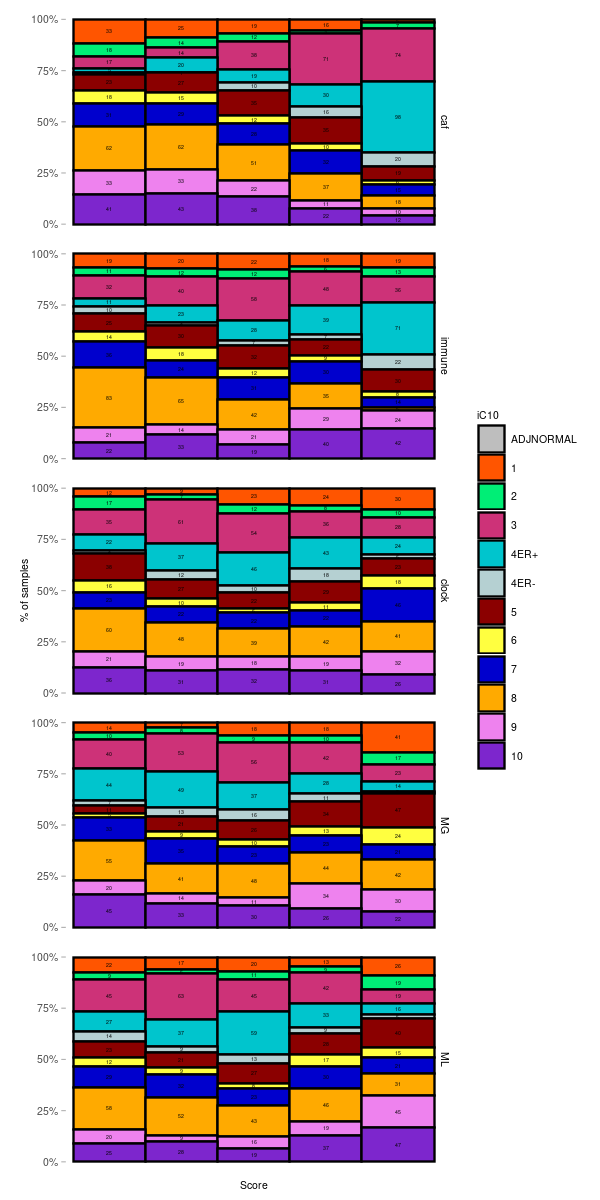

In [95]:
options(repr.plot.width = 5, repr.plot.height = 10)
p_iC10_count <- df_iC10_count %>%
        mutate(feat = factor(feat, levels = c("caf", "immune", "clock", "MG", "ML"))) %>% 
        filter(!is.na(feat)) %>% 
        ggplot(aes(fill = iC10, y = p, x = score, label = n)) +
        geom_col(width = 1, color = "black") +
        scale_fill_manual(values = annot_colors$iC10) +
        geom_text(family = "Arial", size = 1, position = position_stack(vjust = 0.5)) +
        guides(color = "none") +
        facet_grid(feat ~ .) +
        ylab("% of samples") +
        xlab("Score") +
        scale_y_continuous(labels = scales::percent) +
        theme(aspect.ratio = 0.6, axis.text.x = element_blank(), axis.ticks.x = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), panel.border = element_blank())

p_iC10_count

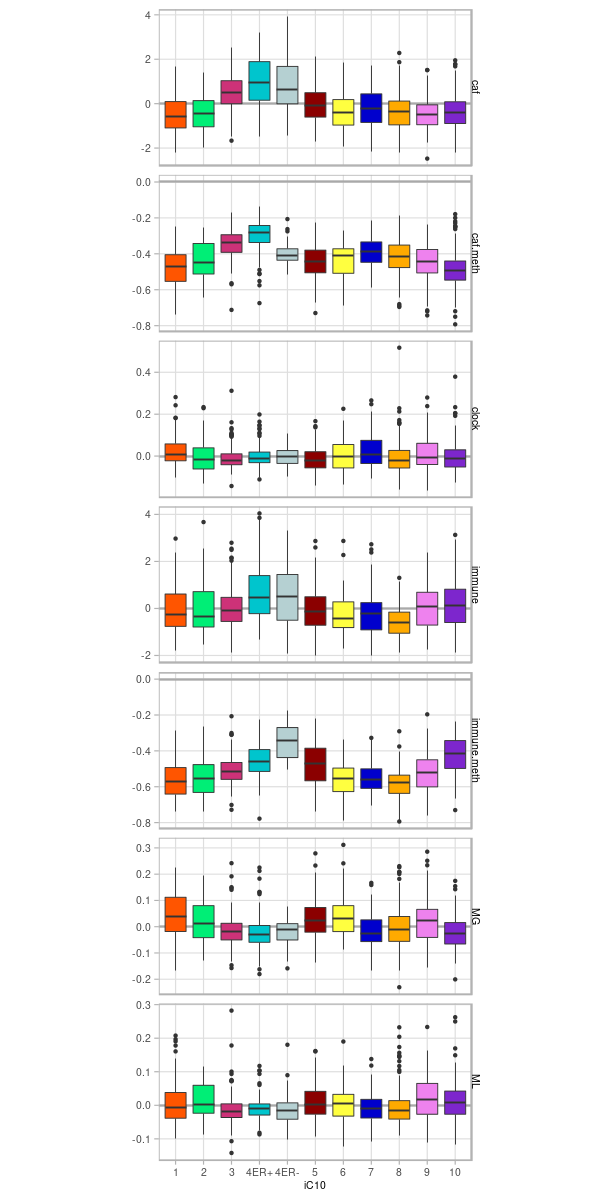

In [97]:
p_ic10 <- df_iC10 %>%
        ggplot(aes(x = iC10, y = score, fill = iC10)) +
        geom_hline(yintercept = 0, color = "darkgray") +
        geom_boxplot(lwd = 0.2, outlier.size = 0.2) +
        scale_fill_manual(values = annot_colors$iC10, guide = "none") +
        facet_grid(feat ~ ., scales = "free_y") +
        ylab("") +
        xlab("iC10") +
        theme(aspect.ratio = 0.5)
p_ic10

## Epipolymorphism of the epigenomic layers

In [98]:
loci_epi_mean <- fread(here("data/loci_epipoly_mean.tsv")) %>% as_tibble() 

In [99]:
gvtrack.create("d_exon", "intervs.global.exon", "distance")
gvtrack.create("d_intron", "intervs.global.introns", "distance")
gvtrack.create("d_promoter", promoter_intervs, "distance")
loci_annot <- gextract.left_join(c("d_promoter", "d_exon", "d_intron"), intervals = loci_annot %>% distinct(chrom, start, end), iterator = loci_annot %>% distinct(chrom, start, end)) %>% 
    as_tibble() %>% 
    right_join(loci_annot, by = c("chrom", "start", "end"))
loci_annot <- loci_annot %>% mutate(type = case_when(
        d_promoter == 0 ~ "promoter",
        d_exon == 0 ~ "exon",
        d_intron == 0 ~ "intron", 
        TRUE ~ "inter-genic"        
    ))

In [100]:
plot_epipoly_strip <- function(df, df_bg, ER, k=15){
    p_bg <- df_bg %>%
        filter(ER == !!ER) %>%
        arrange(pat_meth) %>%
        filter(!is.na(epipoly)) %>% 
        group_by(type) %>% 
        mutate(med = zoo::rollmedian(epipoly, k = k, na.pad = TRUE)) %>%
        ggplot(aes(x = pat_meth, y = epipoly)) +        
        geom_point(size = 0.001, color="gray", alpha=0.5) + 
        geom_line(inherit.aes = FALSE, data = tibble(m = seq(0, 1, by = 0.001)) %>% mutate(epipoly = 2 * m * (1 - m)), linetype = "dashed", aes(x = m, y = epipoly)) +
        geom_line(inherit.aes = FALSE, data = tibble(m = seq(0, 1, by = 0.001)) %>% mutate(epipoly = 1 - ((1 - 2 * m + 2 * m * m)^5)), linetype = "dashed", aes(x = m, y = epipoly)) +
        xlab("Avg. methylation") +
        ylab("Epi-polymorphism")
    df <- df %>% 
        filter(ER == !!ER) %>%
        arrange(pat_meth) %>%
        filter(!is.na(epipoly)) %>% 
        group_by(type) %>% 
        mutate(med = zoo::rollmedian(epipoly, k = k, na.pad = TRUE))
    p <- p_bg + 
        geom_point(data = df, size = 0.001, color="darkred", alpha=0.5) + 
        geom_line(inherit.aes = FALSE, aes(x = pat_meth, y = med), lwd = 0.6) +
        geom_line(data = df, inherit.aes = FALSE, aes(x = pat_meth, y = med), color = "red", lwd = 0.6) +
        theme(aspect.ratio = 1) 
    p + facet_grid(.~type)
}

#### Extended Data Figure 7a

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Warning message:
“Removed 100 row(s) containing missing values (geom_path).”
Warning message:
“Removed 100 row(s) containing missing values (geom_path).”


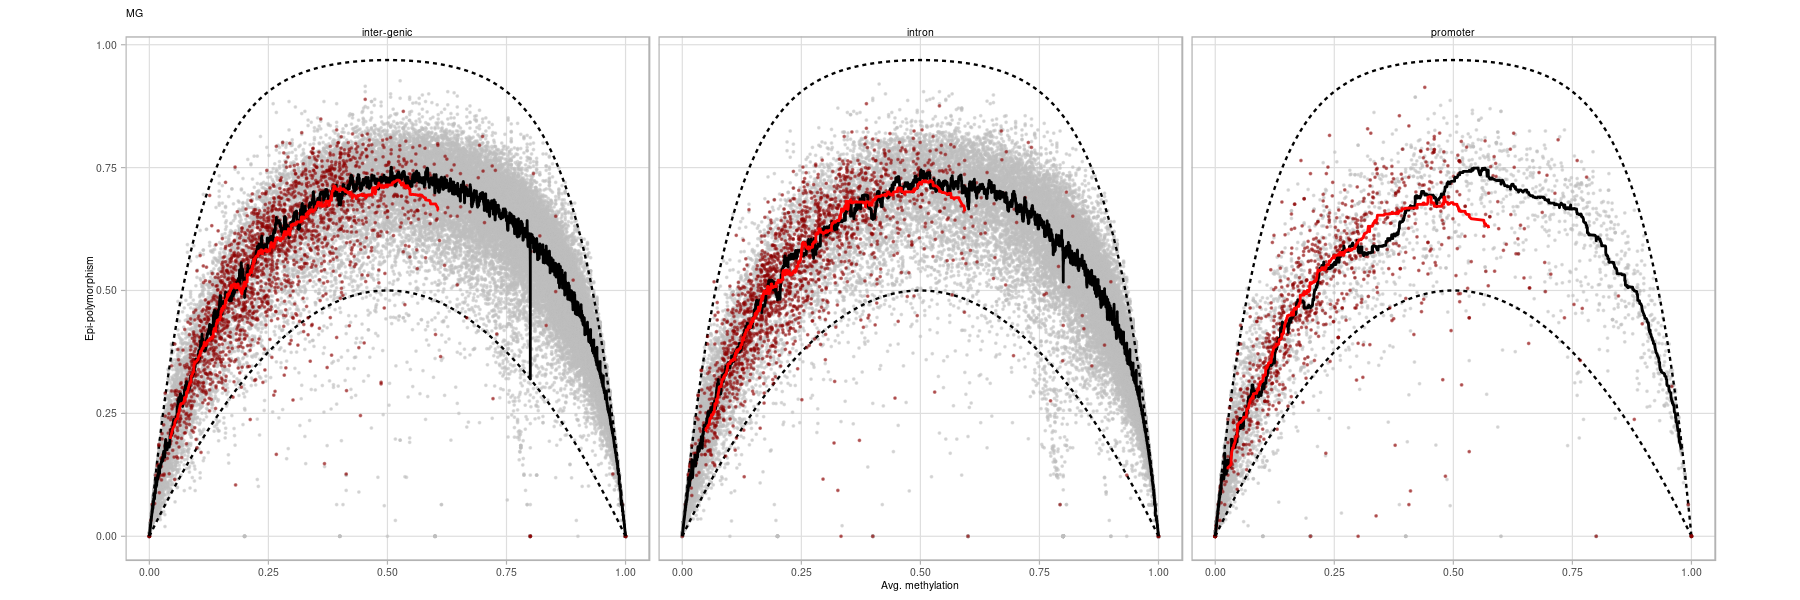

In [101]:
options(repr.plot.width = 15, repr.plot.height = 5)
df <- loci_epi_mean %>% inner_join(loci_annot %>% filter(MG >= 0.5))
df_bg <- loci_epi_mean %>% anti_join(loci_annot %>% filter(MG >= 0.5)) %>% left_join(loci_annot)
p_epipoly_MG <- plot_epipoly_strip(df, df_bg, "ER+", k=101)  + ggtitle("MG")
p_epipoly_MG

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Warning message:
“Removed 100 row(s) containing missing values (geom_path).”
Warning message:
“Removed 109 row(s) containing missing values (geom_path).”


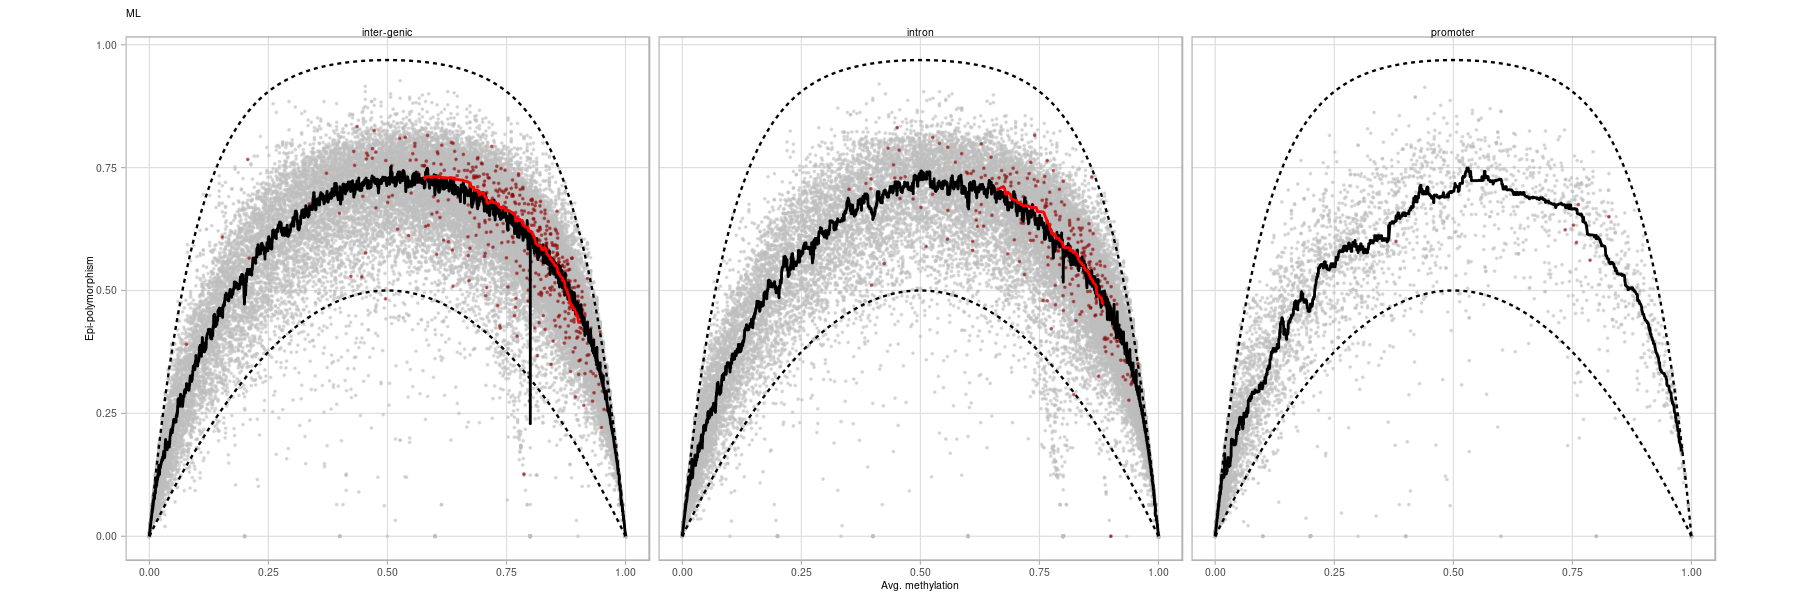

In [102]:
options(repr.plot.width = 15, repr.plot.height = 5)
df <- loci_epi_mean %>% inner_join(loci_annot %>% filter(ML >= 0.5))
df_bg <- loci_epi_mean %>% anti_join(loci_annot %>% filter(ML >= 0.5)) %>% left_join(loci_annot)
p_epipoly_ML <- plot_epipoly_strip(df, df_bg, "ER+", k=101)  + ggtitle("ML")
p_epipoly_ML

## Comparison of the epigenomic scores with existing epigenomic age metrics

### phenoAge

Compare the epigenomic scores with phenoAge score from Steve Horvath's lab (PMID: 29676998)

In [103]:
cpg_450k <- gintervals.load("intervs.450k_27k.cpgs") %>% as_tibble()
pheno_age <- fread(here("data/phenoAge.tsv")) %>% select(id = CpG) %>% left_join(cpg_450k, by = "id") %>% slice(-1) %>% select(chrom, start, end, id) %>% as_tibble()

In [105]:
pheno_age_mb <- fread(here("data/pheno_age_score.tsv")) %>% as_tibble()

Unfortunately, the METABRIC data doesn't cover all of _phenoAge_ CpGs, but we have sufficient CpGs for correlating with the epigenomic scores:

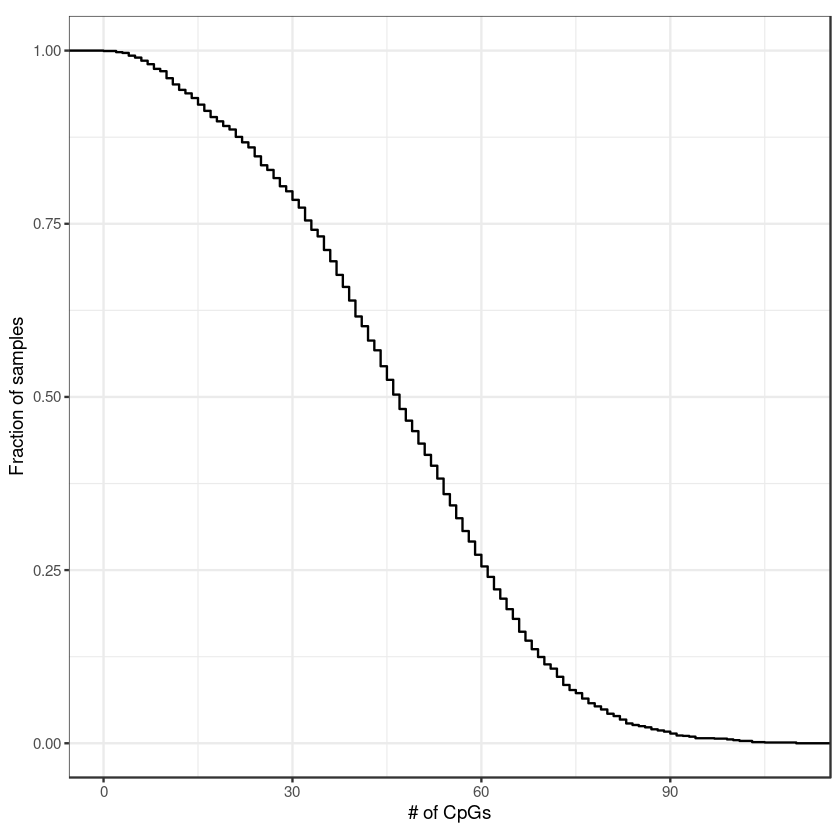

In [106]:
options(repr.plot.width = 7, repr.plot.height = 7)
n_cpgs_pheno <- colSums(!is.na(pheno_age_mb %>% intervs_to_mat())) %>% enframe("samp", "n_cpgs")
n_cpgs_pheno %>% ggplot(aes(x=n_cpgs, y = 1-..y..)) + stat_ecdf() + xlab("# of CpGs") + ylab("Fraction of samples") + theme_bw() + theme(aspect.ratio = 1)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 324 rows containing non-finite values (stat_ecdf).”


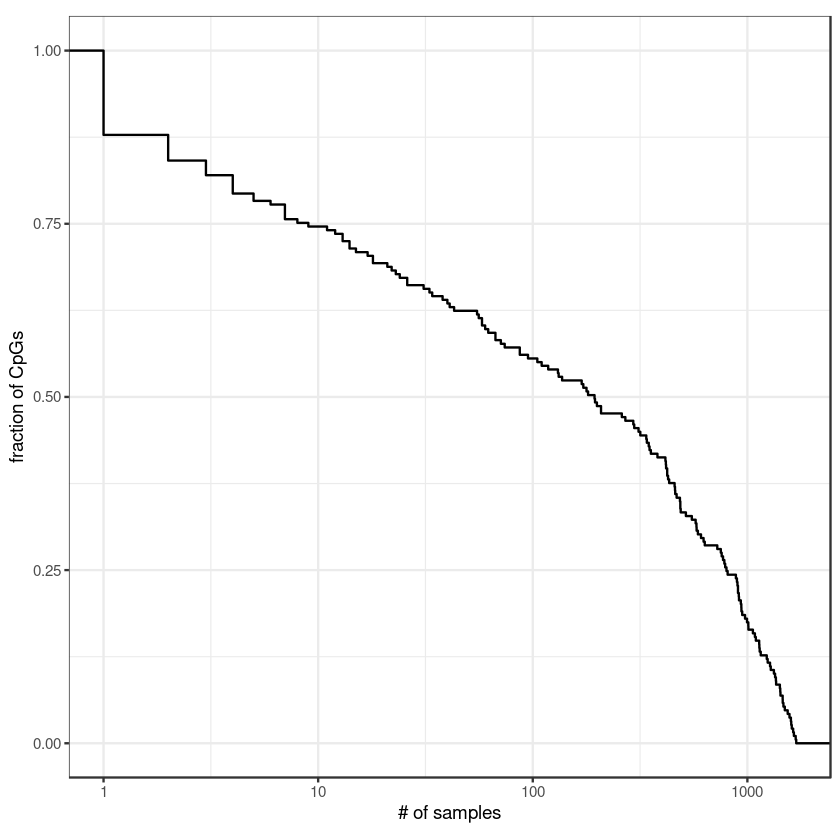

In [107]:
options(repr.plot.width = 7, repr.plot.height = 7)
n_samples_pheno <- rowSums(!is.na(pheno_age_mb %>% intervs_to_mat())) %>% enframe("cpg", "n_samples")
n_samples_pheno %>% ggplot(aes(x=n_samples, y = 1-..y..)) + stat_ecdf() + xlab("# of samples") + ylab("fraction of CpGs") + theme_bw() + theme(aspect.ratio = 1)  + scale_x_log10()

In [108]:
pheno_age_df <- pheno_age_mb %>% intervs_to_mat() %>% colMeans(na.rm = TRUE)  %>% enframe("samp", "pheno_age_score") %>% left_join(n_cpgs_pheno) %>% filter(n_cpgs >= 50)

Joining, by = "samp"



Joining, by = "samp"

Warning message:
“Removed 5649 rows containing missing values (geom_point).”


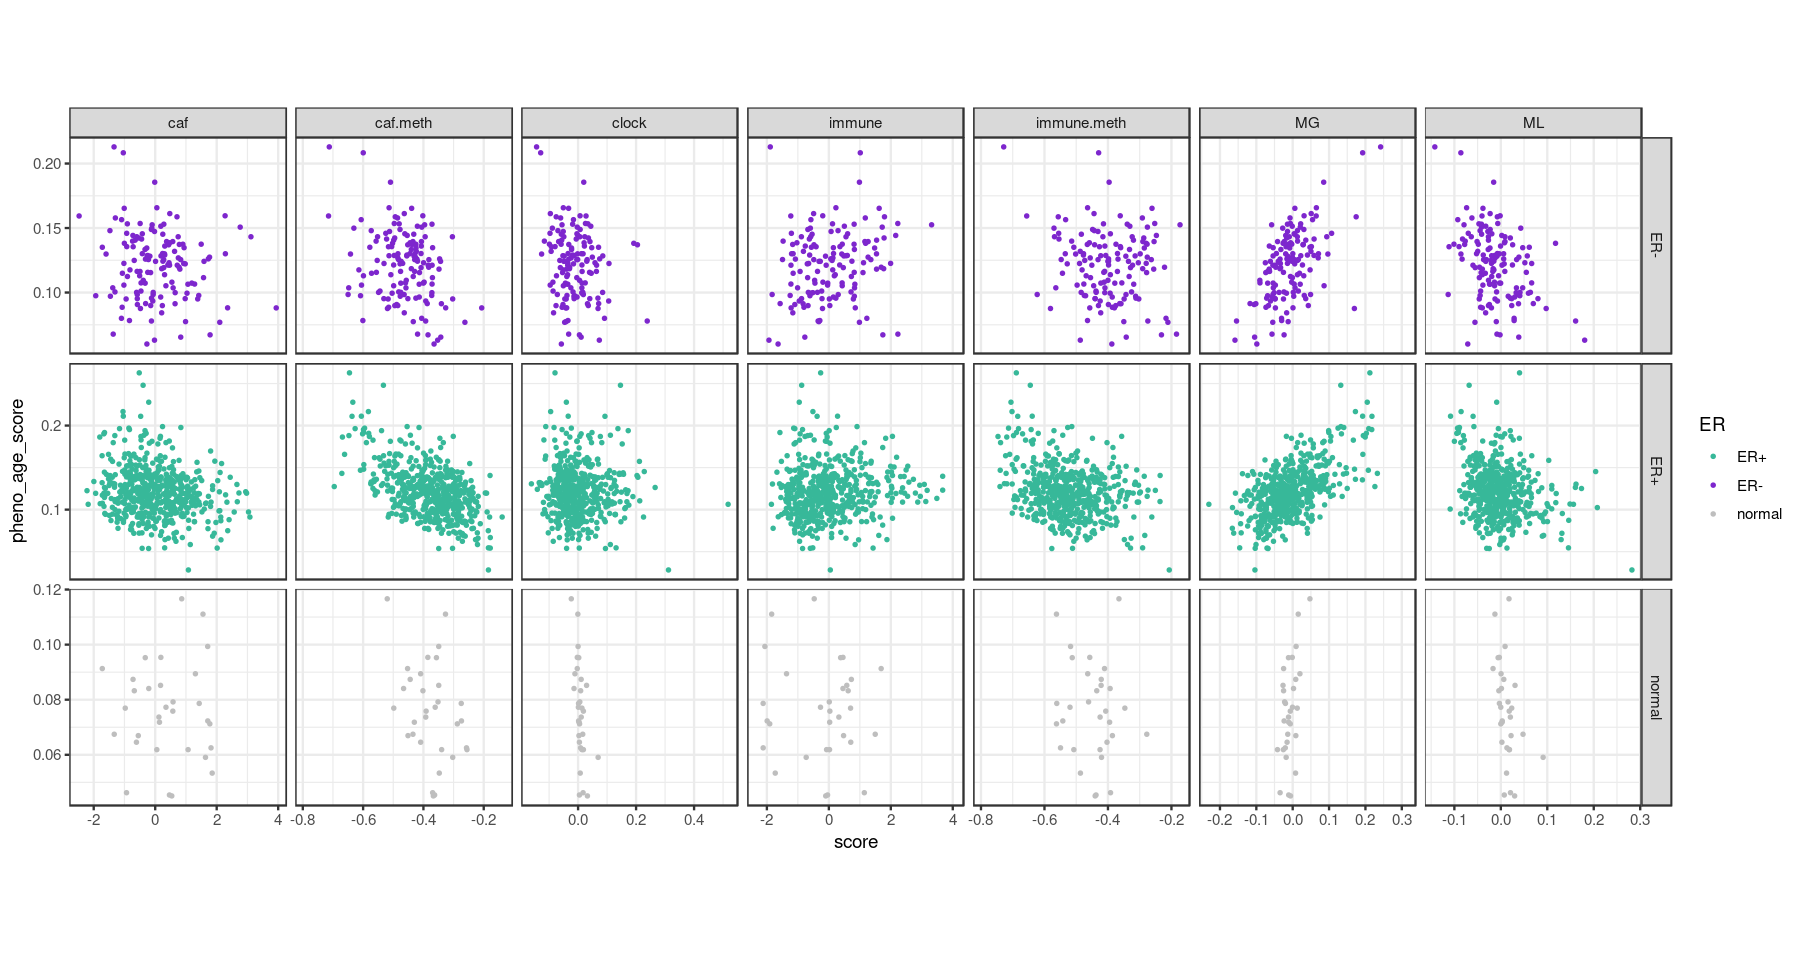

In [119]:
options(repr.plot.width = 15, repr.plot.height = 8)

df <- all_feats %>%     
    gather("feat", "score", clock:immune.meth) %>% 
    left_join(pheno_age_df)

p_pheno_age <- df %>% 
    ggplot(aes(x=score, y=pheno_age_score, color=ER)) + geom_point(size=0.5) + facet_grid(ER~feat, scales="free") + scale_color_manual(values=annot_colors$ER1) +  theme(aspect.ratio=1)

p_pheno_age + theme_bw() + theme(aspect.ratio=1)

In [120]:
df %>% 
    group_by(feat) %>% 
    summarise(cor = cor(pheno_age_score, score, use="pairwise.complete.obs")) %>% 
    arrange(cor) %>% 
    as.data.frame()

feat        cor        
1 caf.meth    -0.45571500
2 ML          -0.28793733
3 immune.meth -0.24872108
4 caf         -0.18080950
5 clock       -0.06886096
6 immune       0.10135506
7 MG           0.56060188

#### Ext Data Figure 5e

Warning message:
“Removed 807 rows containing missing values (geom_point).”


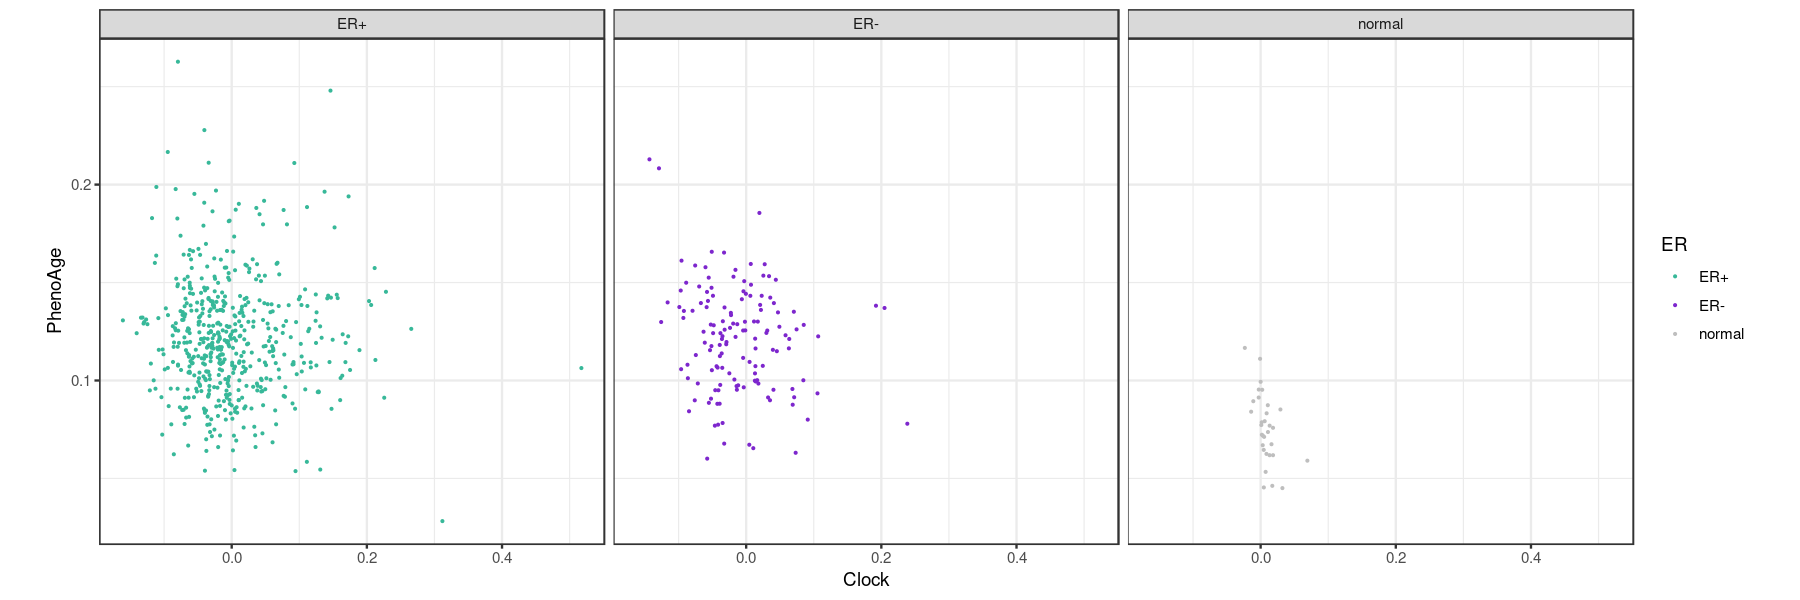

In [121]:
options(repr.plot.width = 15, repr.plot.height = 5)
p_pheno_age_clock <- df %>% 
    filter(feat == "clock") %>% 
    mutate(ER = factor(ER, levels = c("ER+", "ER-", "normal"))) %>%     
    ggplot(aes(x=score, y=pheno_age_score, color=ER)) + geom_point(size=0.1) + facet_grid(.~ER) + scale_color_manual(values=annot_colors$ER1) +  theme(aspect.ratio=1) + ylab("PhenoAge") + xlab("Clock")
p_pheno_age_clock + theme_bw() + theme(aspect.ratio=1)

#### Ext Data Figure 5f

Joining, by = "samp"



cor       
1 0.06263803

Warning message:
“Removed 33 rows containing missing values (geom_point).”


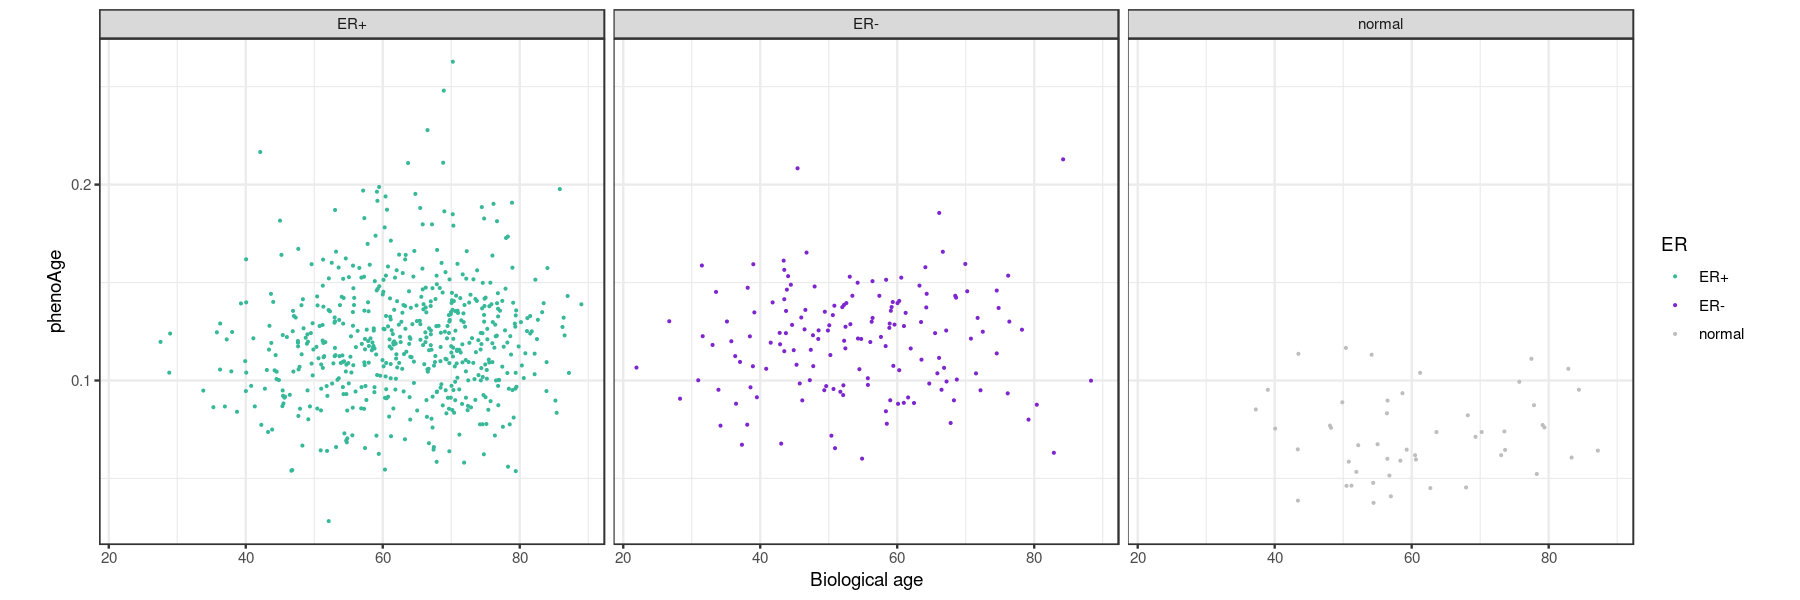

In [122]:
options(repr.plot.width = 15, repr.plot.height = 5)
df <- pheno_age_df %>%     
    left_join(samp_data %>% select(samp, age)) %>% 
    add_ER()

df  %>% summarise(cor = cor(age, pheno_age_score, method = "spearman", use = "pairwise.complete.obs"))

p_age_pheno <- df %>% 
    filter(!is.na(ER)) %>% 
    ggplot(aes(x=age, y=pheno_age_score, color=ER)) + 
        geom_point(size=0.1) + 
        scale_color_manual(values = annot_colors$ER1) + 
        theme(aspect.ratio = 1) + 
        facet_grid(.~ER) + 
        xlab("Biological age") + 
        ylab("phenoAge")

p_age_pheno + theme_bw() + theme(aspect.ratio = 1)

In [116]:
feats_mat <- all_feats %>% select(-ER) %>% column_to_rownames("samp") %>% as.matrix()
pheno_mat <- intervs_to_mat(pheno_age_mb)
samples <- intersect(colnames(pheno_mat), rownames(feats_mat))
cor_pheno <- tgs_cor(feats_mat[samples, ], t(pheno_mat[, samples]), pairwise.complete.obs=TRUE) %>% t() %>% mat_to_intervs() %>% as_tibble()

#### Ext Data Figure 5d

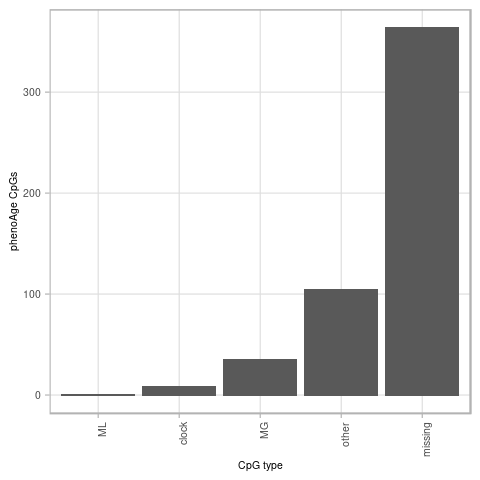

In [117]:
options(repr.plot.width = 4, repr.plot.height = 4)
cor_thresh <- 0.25
cor_pheno <- cor_pheno %>% mutate(type = case_when(clock >= cor_thresh ~ "clock", MG >= cor_thresh ~ "MG", ML >= cor_thresh ~ "ML", is.na(MG) | is.na(ML) | is.na(clock) ~ "missing", TRUE ~ "other"))
p_pheno_cpgs <- cor_pheno %>% 
    count(type) %>% 
    ggplot(aes(x=reorder(type, n), y=n)) + geom_col() + xlab("CpG type") + ylab("phenoAge CpGs") + vertical_labs()
p_pheno_cpgs

In [ ]:
gc()